In [1]:
import sys
import os
%load_ext autoreload
%autoreload 2

sys.path.append('../')
os.chdir('../')

# Preparation

## Operation

In [2]:
import time
import math
import pickle
from contextlib import nullcontext

import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group


# from model import GPTConfig, GPT
from pe_info.model_nope import GPTConfig as GPTConfig_nope, GPT as GPT_nope
from main_utils import *
from vis_utils import *


# refresh parames from here

from vis_params import * # import the default parameters
config_keys = [k for k, v in globals().items() if not k.startswith(
    '_') and isinstance(v, (int, float, bool, str, type(None)))]
# exec(open('./pe_info/config2_pe/modp/jason_train_addition_bal.py').read()) # overrides from command line or config file
# exec(open('./pe_info/config2_pe/mod3/jason_train_addition_bal.py').read()) # overrides from command line or config file

# exec(open('./pe_info/config2_pe/paridy/jason_train_addition_bal.py').read()) # overrides from command line or config file

# overrides from command line or config file

# exec(open('./pe_info/config2_pe/addition/reverse/jason_train_addition_bal.py').read())
# exec(open('./pe_info/config2_pe/order/jason_train_addition_bal.py').read())
# exec(open('./pe_info/config2_pe/rev/rev16.py').read())
# exec(open('./pe_info/config2_pe/identify/identify9.py').read())
# exec(open('./pe_info/config2_pe/identify/identify9.py').read())

exec(open('./pe_info/config2_pe/wherex/wherex9.py').read())



# exec(open('./pe_info/config2_pe/wherex/wherex78x7.py').read())

# exec(open('./pe_info/config2_pe/wherex/wherex78x7.py').read())

# exec(open('./pe_info/config2_pe/rev/add3.py').read())


# exec(open('./pe_info/config2_pe/modclean/jason_train_addition_bal.py').read())



config = {k: globals()[k] for k in config_keys}  # will be useful for logging
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
val_data_path = start.split(':')[-1] # get the test data path


In [3]:
# for later use in torch.autocast
device_type = 'cuda' if 'cuda' in device else 'cpu'
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32,
           'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(
    device_type=device_type, dtype=ptdtype)

# poor man's data loader
if data_type == 'binary':
    data_dir = os.path.join('data', dataset)
    train_data = np.memmap(os.path.join(
        data_dir, train_data_path), dtype=np.uint16, mode='r')
    val_data = np.memmap(os.path.join(
        data_dir, val_data_path), dtype=np.uint16, mode='r')
    if train_both:
        train_data2 = np.memmap(os.path.join(
            data_dir, train_data_path2), dtype=np.uint16, mode='r')
        val_data2 = np.memmap(os.path.join(
            data_dir, val_data_path2), dtype=np.uint16, mode='r')
    if eval_text:
        if eval_text_data_path is None:
            print(
                'eval_text_data_path is None!!! No binary file to evaluate perplexity on.')
        eval_text_data = np.memmap(
            eval_text_data_path, dtype=np.uint16, mode='r')
    # test_data_str = None # test_data for addition testing will be handled with "start"
    meta_path = None
else:
    # check for data_format
    if data_type == 'text':
        if ('reverse' in data_format and not reverse_c) or (reverse_c and 'reverse' not in data_format):
            raise ValueError(
                'reverse_c must be True for data_format == "reverse"')
        elif (data_format == 'algo_reasoning' and not algo_reason) or (algo_reason and data_format != 'algo_reasoning'):
            raise ValueError(
                'algo_reason must be True for data_format == "algo_reasoning"')
    meta_path_specified = False

    data_dir = os.path.join('data', dataset)
    train_data_path = os.path.join(data_dir, train_data_path)
    # val_data = os.path.join(data_dir, val_data_path)
    train_data_list = get_data_list(
        train_data_path, operator=operator)  # a list of (x, y, op)
    val_data_list = get_data_list(filename=val_data_path, operator=operator)
    train_data_str = generate_data_str(train_data_list, operator=operator, format=data_format, train=True,
                                       shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C)
    val_data_str = generate_data_str(val_data_list, operator=operator, format=data_format, train=True,
                                     shuffle=data_shuffle, add_space=add_space, simple=simple, random_A=random_A, random_C=random_C)
    meta, meta_path, data_encoder, data_decoder = create_meta_file(
        vocabulary=vocabulary, input_data_str=train_data_str, tokenizer=tokenizer_type)
    meta_vocab_size = meta['vocab_size']
    train_data = data_encoder(train_data_str)
    val_data = data_encoder(val_data_str)
    if eval_addition_train and start_train is None:
        # specify the start_train to be our train data file
        start_train = f"FILE:{train_data_path}"

    if train_both:
        # This is for the case where we use two different datasets for training
        # we sample from both with a specified ratio - data_ratio
        # TODO: let's leave this here for now.
        train_data2 = np.memmap(os.path.join(
            data_dir, train_data_path2), dtype=np.uint16, mode='r')
        val_data2 = np.memmap(os.path.join(
            data_dir, val_data_path2), dtype=np.uint16, mode='r')

    if eval_text:
        # eval_text_data = np.memmap(eval_text_data_path, dtype=np.uint16, mode='r')
        text_data_list = get_data_list(eval_text_data_path, operator='text')
        text_data_str = generate_data_str(
            text_data_list, operator='text', format=data_format, train=False, shuffle=False)
        eval_text_data = data_encoder(text_data_str)

Creating meta file for all reasonable characters...
all the unique characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~
vocab size: 96
data has 218,925 tokens
data has 218,885 tokens


In [4]:
from numpy import block


space_token = data_encoder(' ')[0]
switch_line_token = data_encoder('\n')[0]
equal_token = data_encoder('=')[0]
dollar_token = data_encoder('$')[0]
# non_causal_fix_length = 15
# non_causal_fix_length = 27
answer_length = 1


def get_batch(split, autoregressive_training=False, batch_size=batch_size):
    global causal_training
    attn_mask = None
    w = None
    data = train_data if split == 'train' else val_data
    if train_both:
        data2 = train_data2 if split == 'train' else val_data2
        batch_size2 = int(batch_size*data_ratio)
        ix = torch.randint(len(data) - block_size, (batch_size-batch_size2,))
        ix2 = torch.randint(len(data2) - block_size, (batch_size2,))
    else:
        if causal_training:
            ix = torch.randint(len(data) - block_size, (batch_size,))
        else:
            split_points = np.where(data == (switch_line_token))[0]
            answer_split_points = np.where(data == (equal_token))[0]
            answer_length_list = split_points - answer_split_points - 1
            split_points = split_points + 1  # i should have had this
            split_points = np.hstack([np.array([0]), split_points.flatten()])

            sample_length_list = np.diff(split_points)
            start_points = split_points[:-1]

            randidx = np.random.permutation(len(start_points))[:batch_size]
            ix = start_points[randidx]
            sample_length_list = sample_length_list[randidx]
            answer_length_list = answer_length_list[randidx]

    if causal_training:
        x = torch.stack(
            [torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
        y = torch.stack(
            [torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    else:
        remove_dollar_count = 1 if dollar_token in data else 0
        if not autoregressive_training:
            cur_answer_length_list = np.random.randint(
                1+remove_dollar_count, answer_length_list+1) + 1
        else:
            cur_answer_length_list = answer_length_list + 1 + 4
        x = [data[ix[i]:ix[i]+sample_length_list[i]-cur_answer_length_list[i]
                  ].astype(np.int64) for i in range(len(ix))]
        x_len = [len(x[i]) for i in range(len(x))]
        pad_to_length = max(x_len)
        min_length = min(x_len)
        # only do padding when the length is not equal
        if pad_to_length > min_length:
            x = np.vstack([np.pad(x[i], (pad_to_length-len(x[i]), 0), mode='constant',
                          constant_values=space_token) for i in range(len(x))])
            attn_mask = np.ones_like(x)
            # mask out the paddings
            attn_mask[x == space_token] = 0
            attn_mask = attn_mask[..., None]
            attn_mask = attn_mask @ attn_mask.transpose(0, 2, 1)
            attn_mask = attn_mask.astype(bool)
            if (attn_mask == 1).all():
                attn_mask = None
            else:
                attn_mask = torch.from_numpy(attn_mask)
        else:
            x = np.vstack(x)
            attn_mask = None

        x = torch.from_numpy(x)
        # predict the next digit
        if not autoregressive_training:
            y = torch.stack([torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i] +
                            1+sample_length_list[i]-cur_answer_length_list[i]]).astype(np.int64)) for i in range(len(ix))])
        else:
            y = [torch.from_numpy((data[ix[i]+sample_length_list[i]-cur_answer_length_list[i]:ix[i]-1+sample_length_list[i]]).astype(np.int64)) for i in range(len(ix))]
            max_len_y = max([len(y[i]) for i in range(len(y))])
            y = np.vstack([np.pad(y[i], (0, max_len_y-len(y[i])), mode='constant',
                          constant_values=space_token) for i in range(len(y))])
            y = torch.from_numpy(y)
            w = torch.ones_like(y)
            w[y == space_token] = 0

    if train_both:
        x2 = torch.stack(
            [torch.from_numpy((data2[i:i+block_size]).astype(np.int64)) for i in ix2])
        y2 = torch.stack(
            [torch.from_numpy((data2[i+1:i+1+block_size]).astype(np.int64)) for i in ix2])
        x = torch.cat([x, x2])
        y = torch.cat([y, y2])

    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(
            device, non_blocking=True)
        if autoregressive_training:
            w = w.pin_memory().to(device, non_blocking=True)
        if attn_mask is not None:
            attn_mask = attn_mask.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

        if attn_mask is not None:
            attn_mask = attn_mask.to(device)

    # attn_mask = None
    return x, y, attn_mask, w

data has 1 tokens
data has 1 tokens
data has 1 tokens
data has 1 tokens


In [5]:
causal_training = False
x, y, z, w = get_batch('test', autoregressive_training=False, batch_size=1)

print(x.shape, y.shape)
if z is not None:
    print(z.shape)

for hidx in range(min(10, len(x))):
    print(data_decoder(x[hidx].cpu().numpy()), data_decoder(y[hidx].cpu().numpy()))
    for xi in x[hidx].cpu().numpy():
        print(data_decoder(xi[..., None]), end=',')
    print()

torch.Size([1, 20]) torch.Size([1, 1])
wherex(585739270,7)= 3
w,h,e,r,e,x,(,5,8,5,7,3,9,2,7,0,,,7,),=,


In [6]:

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9
best_perplexity = 1e9  # on text data
best_accuracy = -1  # on addition data

if meta_path_specified:
    # attempt to derive vocab_size from the dataset
    meta_path = os.path.join(data_dir, 'meta.pkl')
    meta_vocab_size = None
    if os.path.exists(meta_path):
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f)
        meta_vocab_size = meta['vocab_size']
        print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")
    else:
        meta_path = None

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout)  # start with model_args from command line


# init a new model from scratch
print("Initializing a new model from scratch")
# determine the vocab size we'll use for from-scratch training
if meta_vocab_size is None:
    print("defaulting to vocab_size of GPT-2 to 50304 (50257 rounded up for efficiency)")
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304

encode, decode = get_encode_decode(meta_path, tokenizer=tokenizer_type)

Initializing a new model from scratch
Loading meta from meta_all_ascii_chars.pkl...
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])


In [7]:
# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout, use_flash=use_flash,
                  use_residual=use_residual, use_pe=use_pe,
                  no_att_residual=no_att_residual,
                  no_mlp_residual=no_mlp_residual,
                  layerwise_pe=layerwise_pe,
                  permute=permute,
                  not_causal=not_causal
                  )  # jason's change
model_args['vocab_size'] = meta_vocab_size if meta_vocab_size is not None else 50304
# if use_pe=='original':
#     gptconf = GPTConfig(**model_args)
#     model = GPT(gptconf)
# elif use_pe == 'nope':
gptconf = GPTConfig_nope(**model_args)
model = GPT_nope(gptconf)
model = model.to(device)

Using Flash Attention
Block 0: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 1: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 2: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 3: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 4: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
Using Flash Attention
Block 5: 1.0 | att_res True | perm 0.0 | mlp_res True | layerwise_pe 0.0 | casual True
PE in use: original
number of parameters: 10.66M
test_run
0 
1 
2 
3 
4 
5 
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(96, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (pre_att_identity): Identity()
          (c_

In [8]:
x, y, z, w = get_batch('valid', autoregressive_training=True, batch_size=1)
print(w.sum())
with torch.no_grad():
    # model.autoregressive_training(x, y, max_new_tokens=y.shape, attn_mask=z)
    model.train()
    # outs, loss = model(x, y, attn_mask=z, causal_training=causal_training)
    outs, loss = model.autoregressive_training(
        x, y, w,  max_new_tokens=y.shape[-1], attn_mask=z)

    print(decode(x[:10].flatten().detach().cpu().numpy()))
    print(y[:10])
    print(decode(y[:10].flatten().detach().cpu().numpy()))
    print(decode(outs[:10].argmax(-1).flatten().detach().cpu().numpy()))
    print(loss)

tensor(5, device='cuda:0')
wherex(708982578
tensor([[13, 24, 10, 30, 17]], device='cuda:0')
,7)=0
H/3,k
tensor(4.5483, device='cuda:0')


# Predicting on reverse

## Define functions

In [9]:
import plotly.graph_objs as go
from sklearn.decomposition import PCA

import torch
import random


def load_checkpoint(ckpt_path, 
                    model_config, 
                    model_type, 
                    device='cuda', 
                    return_config=False, 
                    return_model=True,
                    init=False,
                    init_additional_config={},):
    # load ckpt into model
    checkpoint = torch.load(ckpt_path, map_location=device)

    model_args = checkpoint['model_args']
    # for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    # model_args[k] = checkpoint_model_args[k]
    # for k in checkpoint_model_args:
    #         model_args[k] = checkpoint_model_args[k]
    # create the model
    original_gptconf = model_config(**model_args)
    gptconf = model_config(**model_args)
    if return_model:
        if not init:
            model = model_type(original_gptconf)
            
            state_dict = checkpoint['model']
            # fix the keys of the state dictionary :(
            # honestly no idea how checkpoints sometimes get this prefix, have to debug more
            unwanted_prefix = '_orig_mod.'
            for k, v in list(state_dict.items()):
                if k.startswith(unwanted_prefix):
                    state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
            model.load_state_dict(state_dict)
        else:
            # override with keys
            for k in init_additional_config:
                original_gptconf.__dict__[k] = init_additional_config[k]
            model = model_type(original_gptconf)
   
    if return_config:
        if return_model:
            return model, gptconf
        else: 
            return gptconf
    else:
        return model


def generate_output(model, 
                    prompt, 
                    max_new_tokens=5, 
                    attn_mask=None, 
                    top_k=None):
    # temperature = 0.8
    # top_k = 200

    model.eval()
    model.to(device)
    if compile:
        model = torch.compile(model)  # requires PyTorch 2.0 (optional)
    # run generation

    start_ids = encode(prompt)
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    with torch.no_grad():
        num_samples = 1
        for k in range(num_samples):

            attn_mask = None

            y = model.generate(x, max_new_tokens,
                               attn_mask=attn_mask, top_k=top_k)

    return decode(y[0].tolist())


def PCA_analysis(prompt, embs, out_text, config_dir):
    pca = PCA(n_components=2)
    new_x = pca.fit_transform(embs.cpu().numpy())
    data = []
    for i, (text, pt) in enumerate(zip(prompt, new_x)):
        trace = go.Scatter(
            x=[pt[0]],
            y=[pt[1]],
            mode='markers+text',
            marker=dict(size=10),  # Adjust the size of the points
            text=[str(i+1)],
            textposition='middle center',  # Center the text within the marker
            name=text,
            textfont=dict(
                family='Times New Rotman',  # Specify the font family
                size=18,  # Adjust the font size
                color='black',  # Adjust the font color
            ),
        )
        data.append(trace)

    layout = go.Layout(
        xaxis=dict(title='Principal Component 1'),
        yaxis=dict(title='Principal Component 2'),
        title=f'PCA visualization for {prompt}'
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()
#   out_num = out_text.split('=')[-1][:-1]
#   eqn = out_text.split('=')[0]
#   out_text = eqn+'='+out_num[::-1]+out_text[-1]
    print(out_text)
    # print(new_x)
    print(pca.explained_variance_ratio_)
    import plotly.io as pio
    pio.write_html(fig, f'./{config_dir}/{prompt}.html')



In [10]:
# config_dir = "out2/addition_reverse/"

# ckpt = f"{config_dir}/ckpt_10000_final.pt"
# import yaml
# with open(f'{config_dir}/addition_reverse/config.yaml') as f:
#   config_dict = yaml.load(f, Loader=yaml.FullLoader)

# gptconf = GPTConfig_nope(**model_args)
# model = GPT_nope(gptconf)
# model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope)
# model = load_checkpoint(ckpt, GPTConfig, GPT)


from collections import Counter
import glob
import yaml


exp_list = []
# exp_list
# exp_list = glob.glob('./outputs/residual_exp/*') + glob.glob('./outputs/nope_residual_exp/*')
# exp_list = glob.glob('./outputs/modp_nope_residual_exp/*') \
#     + glob.glob('./outputs/modp_residual_exp/*') \
#     + glob.glob('./outputs/modp_nc_residual_exp/*') \
#     + glob.glob('./outputs/modp_nc_nope_residual_exp/*') 
# exp_list = glob.glob('./outputs_ref/modclean_nope_nope/*')


# exp_list = glob.glob('./outputs/paridy_nope_residual_exp/*') \
#     + glob.glob('./outputs/paridy_residual_exp/*') \
#     + glob.glob('./outputs/paridy_nc_residual_exp/*') \
#     + glob.glob('./outputs/paridy_nc_nope_residual_exp/*') 


# exp_list = glob.glob('./outputs/mod3_nope_residual_exp/*') \
#     + glob.glob('./outputs/mod3_residual_exp/*') \
#     + glob.glob('./outputs/mod3_nc_residual_exp/*') \
#     + glob.glob('./outputs/mod3_nc_nope_residual_exp/*') 

# exp_list = glob.glob('./outputs/paridy_nope_residual_exp/*')

# exp_list = glob.glob('./outputs/residual_exp/*')
# exp_list = glob.glob('./outputs_permute/add3_nope*/*') \
#     + glob.glob('./outputs_permute/add3_residual*/*') \
#     + glob.glob('./outputs_permute/add3_shuffle_6_*/*') 
# exp_list = glob.glob('./outputs_permute/add3_shuffle_6_*/*')

# exp_list = glob.glob('./outputs_permute/add3_remove_16_*/*') \
#     + glob.glob('./outputs_permute/add3_remove_16_lwp_residual*/*') 
# exp_list = glob.glob('./outputs_permute/add3_remove_8_*/*')


# ===== removing residual connections
# exp_list = glob.glob('./outputs/nope_residual_exp/*')
# exp_list = [p for p in exp_list if 'sd222' in p]

# exp_list += [p for p in glob.glob('./outputs_permute/add3_remove_8_rotary_rotary/*') if 'lwpTrue' not in p]
# exp_list += glob.glob('./outputs_permute/add3_remove_8_T5_T5/*')
# exp_list += [p for p in glob.glob('./outputs_permute/add3_remove_8_sin_residual_exp/*') if 'lwpTrue' not in p]
# exp_list += glob.glob('./outputs_permute/add3_remove_8_residual_exp/*')


# ===== 6-12 layers
exp_list = glob.glob('./outputs_ref_*/rev16*/*') 
# exp_list = glob.glob('./outputs_ref_*/*/*') 

# exp_list = glob.glob('./outputs_ref_6/order*/*') 
# exp_list = glob.glob('./outputs_ref_6/add*/*') 
# exp_list = glob.glob('./outputs_ref/add*/*') 

# exp_list = glob.glob('./outputs_ref_6/wherex9_nc_original_abs/*')
# exp_list = glob.glob('./outputs_ref_6/identify*/*') 




# exp_list = glob.glob('./outputs_ref_2/rev16*/*') 

# exp_list = glob.glob('./outputs_ref_2/wherex78x7*/*') 


    # glob.glob('./outputs_ref/wherex*/*')
# exp_list = [p for p in exp_list if 'order' in p]
# exp_list = [p for p in exp_list if 'rev16' in p]


# exp_list = glob.glob('./outputs_permute/add3_lwp_residual_exp/*')




# exp_list = glob.glob('./outputs_permute/add3_remove_8_sin_sin/*')
# exp_list = glob.glob('./outputs_permute/add3_remove_8_*/*')
# exp_list = exp_list[len(exp_list)//2:]



# exp_list = ['./outputs/nope_residual_exp/addition_reverse_sd111_T2401311659_nope_res=[1, 2, 3, 4, 5]']

# exp_list = [p for p in exp_list if '[0' not in p]
# exp_list  = [p for p in exp_list if 'res=[0, 1, 2, 3, 4, 5]' in p or 'res=[3, 4, 5]' in p]
# exp_list  = [p for p in exp_list if 'res=[0, 1, 2, 3, 4, 5]' in p and '246' not in p and '247' not in p]
# exp_list  = [p for p in exp_list if 'res=[2, 3, 4, 5]' in p]





exp_list = [[x, x.split('/')[-1]] for x in exp_list] 
print(len(exp_list))
# calc ratio
# increase contrast

3


## Activation Correlation

In [11]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
from IPython.utils import io
from tqdm.auto import tqdm

# fixed_length = 10
task_type = 'wherex9'
fixed_length = {
    'add':9,
    'rev16':22,
    'order':19,
    'wherex7':17,
    'wherex9':20,
    'identify':22,
}[task_type]
# fixed_length = 10

# total_tokens = 2048
total_samples = 32
# sample_num = 1024
sample_num = 32

all_level_input_act_list = []
all_out_list = []

rand_perm = False
if rand_perm:
    print("permutation added")
equal_distancing_exp = False
use_1_sample = False
model_init = False
if model_init:
    print("model init")
    init_additional_config = {
        'n_head':1,
    }
    # put additional configs that needs to be initialized here
else:
    init_additional_config = {}

small_dim = False
if small_dim:
    print("small dim")


ablation_config = {
    "V_out": False,
    "no_K": False,
    "no_V": False,
    "no_Q": False,
    "shrink_x": False,
    # "c_proj": True,
    # only one at a time
    "func_config": {
        0: None,
        1:"nodiv", 
        2:"softmax", 
        3:"abs", 
        4:"relu", 
        5:"divsum", 
        6:"gelu",
        7:"gelu_divabs",
        8:"sigmoid",
        9:"same"}[0],
}
for k in ablation_config:
    if ablation_config[k]:
        if k == "func_config":
            print(f"{k}: {ablation_config[k]}")
        else:
            print(f"{k} is on")

model_list = []
useful_name_list = []
for idx, (config_dir, model_config_fold) in enumerate(tqdm(exp_list)):
    glob_dir = config_dir.replace("[", "*").replace("]", "*")
    try:
        yaml_path = glob.glob(f"{glob_dir}/**/config.yaml")[0]
        csv_path = glob.glob(f"{glob_dir}/**/result.csv")[0]
        revised_glob_dir = "/".join(yaml_path.split("/")[:-2])
        exp_list[idx][0] = revised_glob_dir
        exp_list[idx][1] = revised_glob_dir.split("/")[-1]

        config_dir = "/".join(yaml_path.split("/")[:-2])
        with open(yaml_path) as f:
            config_dict = yaml.load(f, Loader=yaml.FullLoader)
        df = pd.read_csv(csv_path)
        
        # ckpt = f"{config_dir}/ckpt_10000_acc.pt"
        glob_dir = config_dir.replace("[", "*").replace("]", "*")
        try:
            all_ckpts = sorted(glob.glob(f"{glob_dir}/ckpt_*.pt"), key=lambda x: int(x.split('_')[-1].split('.')[0]))
        except:
            all_ckpts = [gdir for gdir in glob.glob(f"{glob_dir}/ckpt_*.pt") if '_acc' in gdir]
        # ckpt = f"{config_dir}/ckpt_2000_acc.pt"
    
        gptconfig = load_checkpoint(all_ckpts[0], GPTConfig_nope, GPT_nope, device='cuda', return_config=True, return_model=False)
        if gptconfig.n_embd != 384: continue
        if gptconfig.n_layer != 6 : continue
        
        # add the initialized model
        set_seed(np.random.randint(0,200))
        for init_scheme in [
                            'default',
                            # # "('normal',0,0.002)", 
                            # "('normal',0,0.02)",
                            # # "('normal',0,0.2)",
                            # # "('normal',0,2)", 
                            # # "('normal',4,0.02)",
                            # # "('normal',8,0.02)",
                            # # "('normal',100,0.02)",                        
                            # '("uniform",-0.02,0.02)', 
                            # '("uniform",-0.001,0.001)', 

                            # '("uniform",-1,1)', 
                            # '("uniform",-10,10)', 

                            # '(xavier,1)'
                            ]:
        # for init_scheme in ['default']:

            ckpt = all_ckpts[0]
            print(ckpt)
            with io.capture_output() as captured:
                model, gptconfig = load_checkpoint(
                    ckpt,
                    GPTConfig_nope,
                    GPT_nope,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    return_config=True,
                    init=True,
                    # init_additional_config={
                    #     'init_scheme': init_scheme,
                    # },
                )

            model.eval()
            model.to(device)
            model_list.append(model)
            try:
                iter_num = int(ckpt.split('_')[-1].split('.')[0])
                convergence = 0
                cur_model_name = 'acc='+str(int(convergence))+ '_' \
                    + '/'.join(ckpt.split('/')[3:]).replace(str(iter_num), '0') \
                    + f'_nembd={gptconfig.n_embd}_nlayers={gptconfig.n_layer}' + f'_{init_scheme}'
            except:
                cur_model_name = 'acc=0'+ '_' \
                    + '/'.join(ckpt.split('/')[3:]) \
                    + f'_nembd={gptconfig.n_embd}_nlayers={gptconfig.n_layer}' + f'_Init_{init_scheme}'
            useful_name_list.append(cur_model_name)
            
        # for ckpt in all_ckpts[len(all_ckpts)//2:len(all_ckpts)//2+1] + all_ckpts[-1:]:

        '''get trained model results'''
        # for ckpt in all_ckpts[-1:]:

        for ckpt in all_ckpts:

            with io.capture_output() as captured:
                # model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')
                # model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
                model, gptconfig = load_checkpoint(
                    ckpt,
                    GPTConfig_nope,
                    GPT_nope,
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    return_config=True,
                    init=model_init,
                    init_additional_config=init_additional_config,
                )
                if small_dim:
                    gptconfig.n_head = 1
                    # gptconfig.not_causal = True
                    gptconfig.n_embd = 16
                    model = GPT_nope(gptconfig)
                                
                model.eval()
                model.to(device)
                model_list.append(model)
                try:
                    iter_num = int(ckpt.split('_')[-1].split('.')[0])
                    convergence = df.loc[df['iter']==iter_num, 'test_acc'].values[0]
                  
                except:
                    convergence = df.loc[:, 'test_acc'].values.max()
                cur_model_name = 'acc='+str(int(convergence))+ '_' \
                        + '/'.join(ckpt.split('/')[3:]) \
                        + f'_nembd={gptconfig.n_embd}_nlayers={gptconfig.n_layer}' + '_trained'
                useful_name_list.append(cur_model_name)

    except (ValueError, IndexError) as e:
        print(f"no model {glob_dir}")
        print(e)
        continue

n_embd = model_list[0].config.n_embd
equation_num = 1
causal_training = False # for add3
total_tokens = total_samples * 2 * fixed_length * equation_num
diviser = 256 if causal_training else fixed_length
samples_to_generate = total_tokens//fixed_length + total_tokens%fixed_length
fixed_length = equation_num * fixed_length
print('causal_training is', causal_training)


X = get_batch("valid", batch_size=samples_to_generate)[0]
X = "\n".join([decode(X[i].tolist()) for i in range(X.shape[0])])[:total_tokens] # truncate x to lower computation
equations = X.split('\n')
X_n = []
for eidx in range(0, len(equations), equation_num):
    full_eqn = '\n'.join(equations[eidx:eidx+equation_num])
    # print(full_eqn)
    if task_type=='add' and not full_eqn.startswith('$'): continue
    if len(full_eqn)<fixed_length:
        if len(full_eqn) < fixed_length//4: continue
        full_eqn = '\n' * (fixed_length-len(full_eqn))  + full_eqn
    full_eqn = full_eqn[:fixed_length]
    X_n.append(full_eqn)
X_n = X_n[:total_samples]
X = torch.tensor(list(map(lambda x: encode(x), X_n)))
print(X.shape)

# X_n = np.array(list(X[:len(X) // fixed_length * fixed_length])).reshape(-1, fixed_length)

if rand_perm: # shuffle in input sequence
    for xidx in range(X.shape[0]):
        X[xidx] = X[xidx, torch.randperm(X[xidx].shape[0])]

X = X.to(device)
if use_1_sample:
    X = X[:1]

for level in range(0, 12):
    level = level - 1
    input_act1_list = [list() for _ in range(len(model_list))]
    out_list = [list() for _ in range(len(model_list))]

    for midx, model in enumerate(model_list):
        if len(model.transformer.h)<=level:
            continue

        activation = {}

        def getActivation(name):
            # the hook signature
            def hook(model, input, output):
                activation[name] = output.detach()

            return hook
    

        # register forward hooks on the layers of choice
        if level >= 0:
            # h1 = model.transformer.h[level].register_forward_hook(
            #     getActivation(f"layer_{level}")
            # )
            # if hook_location == 'pre_attn':
            # h1 = model.transformer.h[level].attn.pre_att_identity.register_forward_hook(
            #     getActivation(f"layer_{level}")
            # )
            # elif hook_location == 'post_attn':
            h1 = model.transformer.h[level].attn.identity.register_forward_hook(
                getActivation(f"layer_{level}")
            )

        else:
            # if 'nope' in exp_list[midx][0]:
            # h1 = model.transformer.drop.register_forward_hook(
            #     getActivation(f"layer_{level}")
            # )
            h1 = model.transformer.drop.register_forward_hook(
                getActivation(f"layer_{level}")
            )
            # else:
            #     h1 = model.transformer.wte.register_forward_hook(
            #         getActivation(f"layer_{level}")
            #     )


        h2 = model.transformer.ln_f.register_forward_hook(
            getActivation("x_out")
        )

        with torch.no_grad():
            out0 = model(
                X, equal_distancing_exp=equal_distancing_exp, ablation_config=ablation_config,
            )[0]
 
        h1.remove()
        h2.remove()

        acts = activation[f"layer_{level}"].detach().cpu().numpy()
        # print('sh',acts.shape)
        
        input_act1_list[midx].append(acts)
        out_arg = out0.argmax(-1).detach().cpu().numpy()
        decoded_out = list(decode(out_arg.flatten()))
        
        out_list[midx] = decoded_out

    for hidx in range(len(input_act1_list)):
        if len(input_act1_list[hidx]) == 0:
            # input_act1_list[hidx] 
            # print(f"no activation for ")
            pass
        else:
            cur_input_act1 = np.concatenate(input_act1_list[hidx], axis=0)
            bs, l, dim = cur_input_act1.shape
            # print(cur_input_act1.shape)
            input_act1_list[hidx] = cur_input_act1.reshape(bs, l, dim)
            # out_list[hidx] = out_list[hidx]

    all_level_input_act_list.append(input_act1_list)
    all_out_list.append(out_list)

  0%|          | 0/3 [00:00<?, ?it/s]

Seeded everything: 30
./outputs_ref_6/rev16_nope_nope/rev16_nope_sd240_T2408251628_nope/ckpt_10000_acc.pt
causal_training is False
torch.Size([32, 20])


In [12]:
len(all_level_input_act_list)

12

In [13]:
useful_name_list

['acc=0_rev16_nope_sd240_T2408251628_nope/ckpt_10000_acc.pt_nembd=384_nlayers=6_Init_default',
 'acc=99_rev16_nope_sd240_T2408251628_nope/ckpt_10000_acc.pt_nembd=384_nlayers=6_trained']

In [23]:
from re import T
import gc
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import re
from requests import get
from sklearn.metrics.pairwise import cosine_similarity

font_path = './timr45w.ttf'  # Update this path
from matplotlib import font_manager
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size':32})
plt.rcParams['axes.labelsize'] =32  # Axis labels
plt.rcParams['xtick.labelsize'] =32  # X-axis tick labels
plt.rcParams['ytick.labelsize'] =32  # Y-axis tick labels
plt.rcParams['legend.fontsize'] =32  # Legend
plt.rcParams['axes.titlesize'] =32  # Title


sim_func = cosine_similarity
# sim_func = lambda x, y: np.dot(x, y.T)
# sim_func = lambda x, y: (x[None, ...] - y[:, None, ...]).sum(axis=-1)
show_vals = False
print(f"using function {repr(sim_func).split(' ')[1]}")

def standardize_rows(matrix):
    """Standardize each row of the matrix."""
    mean = matrix.mean(axis=1, keepdims=True)
    std = matrix.std(axis=1, keepdims=True)
    return (matrix - mean) / std

level_corr_mat_accum = []
# corr_mat = []
u1, u2, u1_name, u2_name = None, None, None, None

task_name = 'add_'
folder_name = f'corr_{task_name}' if not equal_distancing_exp else f'dot_{task_name}'
folder_name += '_trained' if not model_init else '_init'

for k in ablation_config:
    if ablation_config[k]:
        if k == 'func_config':
            folder_name += f'_{ablation_config[k]}'
        else: 
            folder_name += f'_{k}' 
from vis_utils import get_PE_tendency, generate_tendency_map

all_stats = None

def get_corr(sample_idx=0, 
             level=0, 
             standard=6,
             drop_down=[], 
             drop_down2=None, 
             drop_down3=None, 
             plot_type = ['dot', 'corr'],
             all_models = False,
             individual_sample = True,
             before_after = ['training', False,  'attention'],
             save=False,  
             abs=False, 
             save_all=False, 
             accumulate_all=False, 
             subplot_layers=True,):
    # global corr_mat, input_act1_list
    global u1, u2, u1_name, u2_name
    global all_stats

    idx1 = useful_name_list.index(drop_down)
    idx2 = useful_name_list.index(drop_down2) if drop_down2 is not None else None
    idx3 = useful_name_list.index(drop_down3) if drop_down3 is not None else None

    # model_layers = [l[idx1] for l in all_level_input_act_list if len(l[idx1])!=0]
    # level = min(level, len(model_layers)-1)
    # print(level, idx1, useful_name_list[idx1])

    for l in all_level_input_act_list:
        if l == []:
            return

    # individual_sample = individual_sample if not save_all else False
    if individual_sample :
        if not equal_distancing_exp:
            print(X_n[sample_idx:sample_idx+1])
        else:
            print('eqx')
    save = True if save_all else save
    model_range = range(idx1, idx1+1) if not save_all else range(len(useful_name_list))
    all_stats = dict()
    for idx1 in tqdm(model_range):
        eqn_text = X_n[sample_idx] if not equal_distancing_exp else 'eqx'
        
        models_corr_mat_list = []
        models_cm_tend_list = []
        
        model_name = useful_name_list[idx1]
        acc = model_name.split('_')[0]
        rest = '_'.join(model_name.split('_')[1:])
        try:
            iteration = int(re.search(r'acc_(\d+).pt', model_name).group(1))
        except:
            if 'Init' in model_name:
                iteration = 0
            else:
                iteration = 5000
        imgname = rest.replace('10000_acc_', '').replace('/', '_').replace('.pt', '') + ' ' + eqn_text

        cur_model_act_list1 = [l[idx1] for l in all_level_input_act_list if len(l[idx1])!=0]
        models_to_plot = [cur_model_act_list1]
        
        has_model = True
        if before_after=='training':
            rest = '_'.join(rest.split('.')[0].split('_')[:-1])
            if acc.split('=')[-1]!='0' or iteration!=0:
                print(acc, iteration)
                has_model = False
                continue
            trained_model_name = None
            for m_idx, m_name in enumerate(useful_name_list):
                # if rest in m_name and not (m_name==model_name):
                if rest in m_name and 'trained' in m_name:
                    trained_model_name = m_name
                    # trained_cur_model = model_list[m_idx]
                    m_idx = useful_name_list.index(m_name)
                    cur_model_act_list2 = [l[m_idx] for l in all_level_input_act_list if len(l[m_idx])!=0]
                    break
            assert trained_model_name is not None, 'no trained model found'
            print(all_out_list[0][midx][sample_idx])
            models_to_plot.append(cur_model_act_list2)

        elif before_after=='attention':
            models_to_plot.append(cur_model_act_list1)
        else:
            print(all_out_list[0][idx1][sample_idx])
        
        print('output:', all_out_list[0][idx1][sample_idx])


        if drop_down2 is not None:
            cur_model_act_list2 = [l[idx2] for l in all_level_input_act_list if len(l[idx2])!=0]
            models_to_plot.append(cur_model_act_list2)
        if drop_down3 is not None:
            cur_model_act_list3 = [l[idx3] for l in all_level_input_act_list if len(l[idx3])!=0]
            models_to_plot.append(cur_model_act_list3)
        

        for cur_model_act_list in models_to_plot:
            corr_mat_list = []
            level_cm_tend_list = []
            for level in tqdm(range(len(cur_model_act_list))):
                input_act1_list = cur_model_act_list[level]
                # global level_corr_mat_accum

                u1, u2 = cur_model_act_list[level], cur_model_act_list[level]
                # u1 = u1.T
                # u2 = u2.T
                if individual_sample:
                    u1, u2 = u1[sample_idx:sample_idx+1], u2[sample_idx:sample_idx+1]
             
                if plot_type=='corr':
                    corr_mat = []
                    for b1, b2 in zip(u1, u2):
                        u1_standardized = standardize_rows(u1)
                        u2_standardized = standardize_rows(u2)
                        corr_mat.append(np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1]))
                elif plot_type=='dot':
                    corr_mat = []
                    for b1, b2 in zip(u1, u2):
                        corr_mat.append(sim_func(b1, b2))
                    corr_mat_all = np.array(corr_mat)
                    corr_mat = corr_mat_all.mean(axis=0) 

                if abs:
                    corr_mat = np.abs(corr_mat)
                else:
                    pass

                
                cm_tend_list = []
                for _sidx in range(len(corr_mat_all)):
                    cm_tend_list.append(get_PE_tendency(corr_mat_all[_sidx], as_list=True)[standard])
                           
                # if accumulate_all:
                #     level_corr_mat_accum.append(corr_mat[None, ...])

                
                corr_mat_list.append(corr_mat)
                level_cm_tend_list.append(cm_tend_list)               


                if not subplot_layers:
                    vec_dim = corr_mat.shape[0]//fixed_length
                    total_sum = np.abs(corr_mat).sum()
                    block_sum = 0
                    for i in range(0, len(corr_mat), vec_dim):
                        block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
                    ratio = block_sum/(total_sum-block_sum)

                    plt.figure(figsize=(6, 5), dpi=120)
                    plt.imshow(corr_mat, cmap='Reds') #, interpolation='nearest')

                    extra_text = 'Absolute ' if abs else ''
                    plt.colorbar(label=f'{extra_text}Correlation Coefficient')

                    os.makedirs(f'./saved_plots_{folder_name}/', exist_ok=True)
                    plt.savefig(f'./saved_plots_{folder_name}/{useful_name_list[idx1]}_avg_{abs}.pdf')
                    plt.close()
            models_corr_mat_list.append(corr_mat_list)

            models_cm_tend_list.append(level_cm_tend_list)
        # corr_mat_list = models_corr_mat_list
        print(all_out_list[0][idx1][sample_idx])
        
        if subplot_layers and has_model:
            handel=f'{before_after}_{standard}_indi={individual_sample}/'
            folder_dir = f'./saved_plots_sim_test/{handel}'
            # if save:
            #     if f'{folder_dir}/{imgname}.pdf' in glob.glob(f'{folder_dir}/{imgname}.pdf'):
            #         continue
            fig, axs = plt.subplots(len(models_corr_mat_list), len(models_corr_mat_list[0]), figsize=(6*len(models_corr_mat_list[0]), 5.6*len(models_corr_mat_list)))  # 6 subplots in a row, adjust size as needed
            
            for level in range(len(models_corr_mat_list[0])):

                for cm_idx, corr_mat_list in enumerate(models_corr_mat_list):
                    try:
                        corr_mat = corr_mat_list[level]
                    except:
                        print(corr_mat_list)
                        raise ValueError

                    # vec_dim = n_embd
                    cm_tend = get_PE_tendency(corr_mat, as_list=True)[standard]

                    vec_dim = corr_mat.shape[0]//fixed_length

                    total_sum = np.abs(corr_mat).sum()
                    block_sum = 0
                    for i in range(0, len(corr_mat), vec_dim):
                        block_sum += np.abs(corr_mat[i:i+vec_dim, i:i+vec_dim]).sum()
                    ratio = block_sum/(total_sum-block_sum)

                    axloc = axs[level] if len(models_corr_mat_list)==1 else axs[cm_idx, level]

                    cm = axloc.imshow(corr_mat, cmap='Reds') #, interpolation='nearest')
                    # show the number on each block
                    if show_vals:
                        for i in range(0, len(corr_mat), vec_dim):
                            for j in range(0, len(corr_mat), vec_dim):
                                text = axloc.text(j, i, f'{corr_mat[i:i+vec_dim, j:j+vec_dim].sum():.02f}',
                                                    ha="center", va="center", color="black", fontsize=6)

                    training_status = ''
                    if before_after=='training':
                        training_status = 'Trained ' if cm_idx==1 else 'Init '
                    title_text = f'{training_status}Layer {level} ({cm_tend})' if level > 0 \
                        else f'Embeddings ({cm_tend})'                  
                    axloc.set_title(title_text)
                    cbar = plt.colorbar(cm, ax=axloc, orientation='vertical', fraction=0.05, )
                    # Get the scalar formatter from the colorbar
                    from matplotlib.ticker import FormatStrFormatter, MaxNLocator
                    formatter = FormatStrFormatter('%.1f')
                    axloc.yaxis.set_major_formatter(FormatStrFormatter('%d'))
                    axloc.yaxis.set_major_locator(MaxNLocator(nbins=5))

                    axloc.xaxis.set_major_locator(MaxNLocator(nbins=5))

                    # Set the desired format (e.g., rounding to 2 decimal places)
                    # formatter.set_useOffset(False)  # Disable offset if necessary

                    # Apply the formatter to the colorbar
                    cbar.formatter = formatter
                    cbar.update_ticks()
            
            plt.tight_layout()
            fig.subplots_adjust(left=0.03, right=0.975, top=0.95, bottom=0.06, hspace=0.25)
            if save:
                os.makedirs(f'{folder_dir}', exist_ok=True)

                plt.savefig(f'{folder_dir}/{imgname} sample.pdf', format='pdf')
                plt.close()
                gc.collect()
            else:
                plt.show()
            
            '''Plotting the Distribution'''
            
            fig, axs = plt.subplots(len(models_corr_mat_list), len(models_corr_mat_list[0]), figsize=(6*len(models_corr_mat_list[0]), 5.6*len(models_corr_mat_list)))  # 6 subplots in a row, adjust size as needed
            levels_stats = []
            for level in range(len(models_corr_mat_list[0])):
                for cm_idx, level_cm_tend_list in enumerate(models_cm_tend_list):
                    axloc = axs[level] if len(models_corr_mat_list)==1 else axs[cm_idx, level]
                    axloc.hist(level_cm_tend_list[level], bins=32)
                    training_status = ''
                    if before_after=='training':
                        training_status = 'Trained ' if cm_idx==1 else 'Init '
                    mean_tend = round(np.mean(level_cm_tend_list[level]), 2)
                    std_tend = round(np.std(level_cm_tend_list[level]), 2)
                    levels_stats.append(mean_tend)
                    title_text = f'{training_status}Layer {level} ({mean_tend}, {std_tend})' if level > 0 \
                        else f'Embeddings ({mean_tend}, {std_tend})'                
                    axloc.set_title(title_text)                    
                    axloc.set_xlim(-1.05, 1.05)

            
            plt.tight_layout()
            fig.subplots_adjust(left=0.03, right=0.975, top=0.92, bottom=0.08, hspace=0.25)
            dist_name = f'{folder_dir}/{imgname} dist.pdf'
            if save:
                os.makedirs(f'{folder_dir}', exist_ok=True)
                plt.savefig(dist_name, format='pdf')
                plt.close()
                gc.collect()
            else:
                plt.show()
            
            all_stats[dist_name]=levels_stats

        # if idx1 >=10:
        #     raise ValueError
        if accumulate_all:
            level_corr_mat_accum = np.vstack(level_corr_mat_accum)
            print(level_corr_mat_accum.shape)
            level_corr_mat_accum = level_corr_mat_accum.mean(axis=0)
            # Create a heatmap of corr_mat
            if not subplot_layers:
                plt.figure(figsize=(6, 5), dpi=120)
                # plt.imshow(corr_mat, cmap='seismic') #, interpolation='nearest')
                plt.imshow(level_corr_mat_accum, cmap='Reds') #, interpolation='nearest')

                extra_text = 'Absolute ' if abs else ''
                plt.colorbar(label=f'{extra_text}Correlation Coefficient')
                plt.show()
            corr_mat  =  level_corr_mat_accum
            level_corr_mat_accum = []
        return all_stats
        
           
from functools import partial
from vis_utils import get_corr

# get_corr = partial(get_corr, 
#                         useful_name_list=useful_name_list,
#                         all_level_input_act_list=all_level_input_act_list,
#                         sim_func=sim_func,
#                         X_n=X_n,
#                         folder_name='saved_plots_test',
#                         fixed_length=fixed_length,
#                         equal_distancing_exp=equal_distancing_exp,
#                         all_out_list=all_out_list,)

# all_drop_down = [e[1] for e in useful_name_list]
# from vis_utils import get_corr
import ipywidgets as widgets
widgets.interact(get_corr, 
            useful_name_list=[useful_name_list],
            all_level_input_act_list=[all_level_input_act_list],
            sim_func=[sim_func],
            X_n=[X_n],
            folder_name=['saved_plots_test'],
            fixed_length=[fixed_length],
            equal_distancing_exp=[equal_distancing_exp],
            all_out_list=[all_out_list],
            
            sample_idx=(0, len(X_n)-1), 
            drop_down=useful_name_list, 
            drop_down2=[None] + useful_name_list, 
            drop_down3=[None] + useful_name_list, 
            level=(0,12),
            standard=(0,6))






using function cosine_similarity


interactive(children=(Dropdown(description='useful_name_list', options=(['acc=0_rev16_nope_sd240_T2408251628_n…

<function vis_utils.get_corr.get_corr(useful_name_list, all_level_input_act_list, sim_func, X_n, folder_name, fixed_length, all_out_list, equal_distancing_exp=False, sample_idx=0, level=0, standard=6, drop_down=None, drop_down2=None, drop_down3=None, plot_type=['dot', 'corr'], all_models=False, individual_sample=True, before_after=['training', False, 'attention'], save=False, abs=False, save_all=False, accumulate_all=False, subplot_layers=True, show_vals=False)>

In [64]:
useful_name_list

['acc=0_wherex9_nc_original_sd240_T2408310224_ncTrue/ckpt_10000_acc.pt_nembd=384_nlayers=6_Init_default',
 'acc=92_wherex9_nc_original_sd240_T2408310224_ncTrue/ckpt_10000_acc.pt_nembd=384_nlayers=6_trained']

In [71]:
content_dict = get_corr(useful_name_list=useful_name_list,
            all_level_input_act_list=all_level_input_act_list,
            sim_func=sim_func,
            X_n=X_n,
            folder_name='saved_plots_test',
            fixed_length=fixed_length,
            equal_distancing_exp=equal_distancing_exp,
            all_out_list=all_out_list,

            sample_idx=10,
            level=0,
            standard=6,
            drop_down=useful_name_list[0],
            drop_down2=None,
            drop_down3=None,
            plot_type='dot',
            all_models=False,
            individual_sample=True,
            before_after='training',
            save=True,
            abs=False,
            save_all=False,
            accumulate_all=False,
            subplot_layers=True)

list ['acc=0_wherex9_nc_original_sd240_T2408310224_ncTrue/ckpt_10000_acc.pt_nembd=384_nlayers=6_Init_default', 'acc=92_wherex9_nc_original_sd240_T2408310224_ncTrue/ckpt_10000_acc.pt_nembd=384_nlayers=6_trained']
down acc=0_wherex9_nc_original_sd240_T2408310224_ncTrue/ckpt_10000_acc.pt_nembd=384_nlayers=6_Init_default
['wherex(299517340,9)=']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Plotting the Correlation Matrix
Plotting the Distribution
Plotting the Norm
Plotting the Norm Distribution


In [66]:
# cm_dist = {k: v for k, v in content_dict.items() if 'dist.pdf' in k}
# norm_dist = {k: v for k, v in content_dict.items() if 'dist_norm.pdf' in k}
cm_dist, norm_dist = {}, {}
for k in content_dict:
    v = content_dict[k]
    v = [f'{e[0]}\u00B1{e[1]}' for e in v]
    v = np.array(v)
    v = v.reshape(7, -1).T
    cur_dict = cm_dist if 'dist.pdf' in k else norm_dist
    cur_dict[k+' init'] = v[0]
    if len(v) > 1:
        cur_dict[k+' trained'] = v[1]


import pandas as pd
df_cm = pd.DataFrame(cm_dist)
df_cm = pd.DataFrame(df_cm.values.T[:, :], columns=['Embeddings', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6'],
                     index=df_cm.columns)

df_norm = pd.DataFrame(norm_dist)
df_norm = pd.DataFrame(df_norm.values.T[:, :], columns=['Embeddings', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Layer 5', 'Layer 6'],
                     index=df_norm.columns)



[0.91025335 0.86780759 0.92045869]
[0.91016574 0.8677466  0.92040316]
[0.90163697 0.85973646 0.91321696]
[0.54706847 0.52096506 0.56933248]
[0.19130326 0.1811027  0.19976518]
[0.17053029 0.15544022 0.16121777]


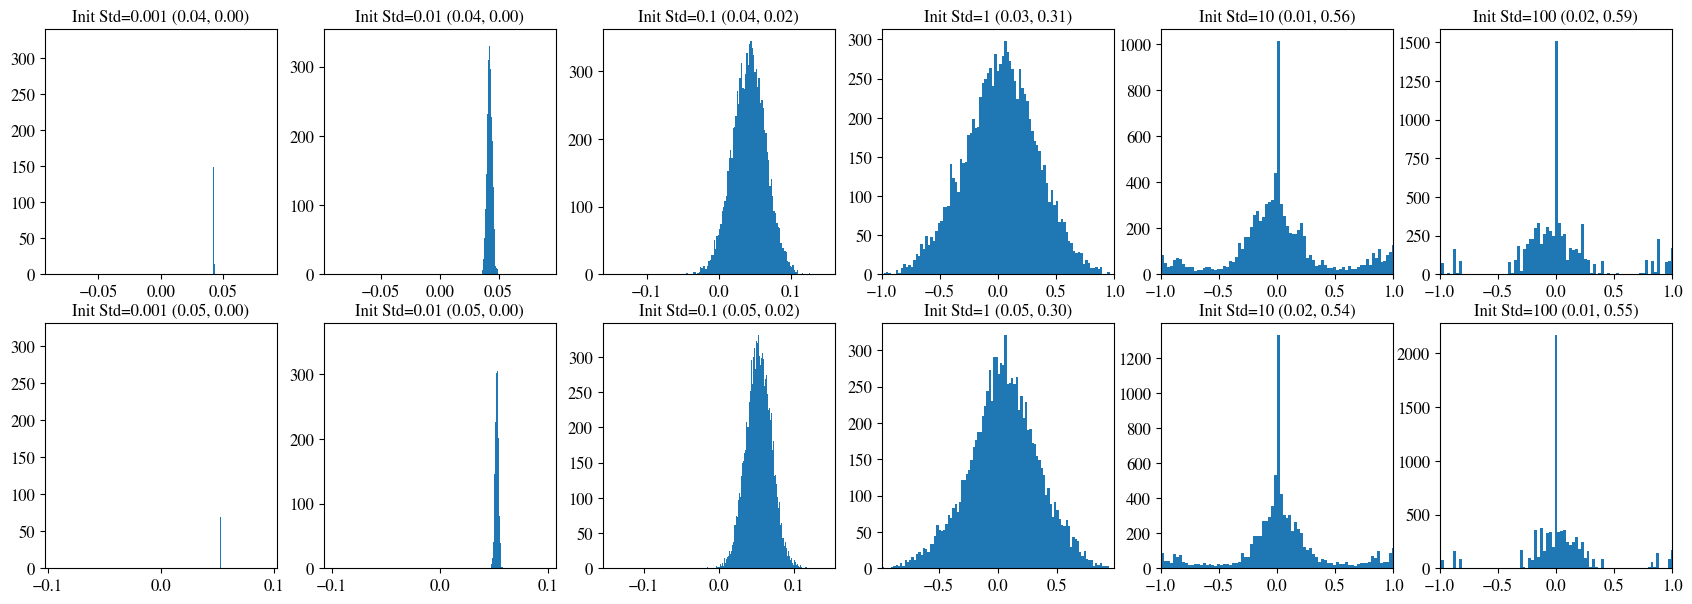

In [158]:
import numpy as np
from matplotlib import font_manager
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size':12})
plt.rcParams['axes.labelsize'] =12  # Axis labels
plt.rcParams['xtick.labelsize'] =12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] =12  # Y-axis tick labels
plt.rcParams['legend.fontsize'] =12  # Legend
plt.rcParams['axes.titlesize'] =12  # Title


vs = np.random.randn(400, 128)

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def my_rand(n, std=0.1):
    #return np.random.uniform(-3, 3, n)
    # return np.random.poisson(3, n)-3.0
    return np.random.normal(0, std, n)


def rep(idx_range = [4,5,6] , std=0.1):


    alpha = my_rand(idx_range[0], std)
    #alpha = alpha / np.sum(alpha)
    alpha = softmax(alpha)


    beta = my_rand(idx_range[1], std) 
    # beta[ 0: 4] += 1.8*alpha 
    #beta = beta / np.sum(beta)
    beta = softmax(beta) 

    gamma = my_rand(idx_range[2], std)
    #gamma = gamma / np.sum(gamma)
    #gamma[ 0: 4] += 0.8*alpha 
    # gamma[0: 5] += 1.8*beta
    gamma = softmax(gamma) 

    # a = alpha[0]*vs[0] + alpha[1]*vs[1] + alpha[2]*vs[2] + alpha[3]*vs[3]
    # b = beta[0]*vs[0] + beta[1]*vs[1] + beta[2]*vs[2] + beta[3]*vs[3] + beta[4]*vs[4]
    # c = gamma[0]*vs[0] + gamma[1]*vs[1] + gamma[2]*vs[2] + gamma[3]*vs[3] + gamma[4]*vs[4] + gamma[5]*vs[5] + gamma[6]*vs[6] + gamma[7]*vs[7] + gamma[8]*vs[8] + gamma[9]*vs[9]
    a = alpha @ vs[:len(alpha)]
    b = beta @ vs[:len(beta)]
    c = gamma @ vs[:len(gamma)]

    return np.array([cos_sim(a, b), cos_sim(a, c), cos_sim(b, c)])


fig, axs = plt.subplots(2, 6, figsize=(21, 7))


bins = 100

for sidx, std in enumerate([0.001, 0.01, 0.1, 1, 10, 100]):

    
    res = np.array([rep(std=std) for i in range(10000)])  
    
    stat1 = res[:, 0]-res[:, 1]

    axs[0, sidx].hist(stat1, bins=bins)
    # axs[0, sidx].set_title(f'mean={stat1.mean():.2f}, std={stat1.std():.2f}')
    axs[0, sidx].set_title(f'Init Std={std} ({stat1.mean():.2f}, {stat1.std():.2f})')

    sz = stat1.mean() + 3*stat1.std() + 0.05
    sz = min(sz, 1)
    axs[0, sidx].set_xlim(-sz, sz)


    stat2 = res[:, 2]-res[:, 1]
    
    axs[1, sidx].hist(stat2, bins=bins)
    axs[1, sidx].set_title(f'Init Std={std} ({stat2.mean():.2f}, {stat2.std():.2f})')
    sz = stat2.mean() + 3*stat2.std()  + 0.05
    sz = min(sz, 1)
    axs[1, sidx].set_xlim(-sz, sz)
    # print(res)

    print(np.mean(res, axis=0))
fig.savefig(f'./saved_plots_test/rep_3.pdf', format='pdf')
plt.show()


  0%|          | 0/74 [00:00<?, ?it/s]

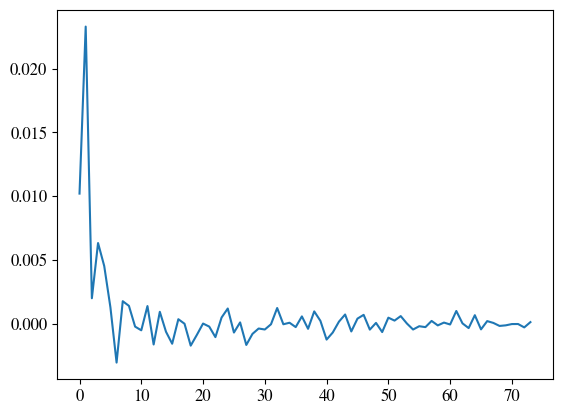

In [162]:


all_means = []
for st in tqdm(range(4,300,4)):
    means = []
    means2 = []
    for i in range(50):
        # for sidx, std in enumerate(np.arange(0.01, 2, 0.01)):
        std = 0.001
            
        res = np.array([rep(idx_range=[st,st+1,st+2], std=std) for i in range(100)])  
        
        stat1 = res[:, 0]-res[:, 1]

        means.append(stat1.mean())

        stat2 = res[:, 2]-res[:, 1]
        
        means2.append(stat2.mean())

    # plt.hist(means, bins=100)
    # plt.show()
    # plt.hist(means2, bins=100)
    # plt.show()
    means = np.array(means)
    means2 = np.array(means2)
    means_diff = means2.mean()-means.mean()
    all_means.append(means_diff)

plt.plot(all_means)


### Manual Avg

In [17]:
# # the difference in projection for the same vector
# # x = torch.rand(1, 1, 384).to(device)
# font_path = './timr45w.ttf'  # Update this path
# from matplotlib import font_manager
# # Add the font to Matplotlib's font manager
# font_manager.fontManager.addfont(font_path)
# prop = font_manager.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()
# plt.rcParams['font.family'] = prop.get_name()
# plt.rcParams.update({'font.size': 14})
# plt.rcParams['axes.labelsize'] = 14  # Axis labels
# plt.rcParams['xtick.labelsize'] = 14  # X-axis tick labels
# plt.rcParams['ytick.labelsize'] = 14  # Y-axis tick labels
# plt.rcParams['legend.fontsize'] = 14  # Legend
# plt.rcParams['axes.titlesize'] = 14  # Title

# n_embd = 384
# x = torch.zeros(1, 1, n_embd).to(device)
# sc = torch.rand(1, 1, n_embd).to(device)

# idx = np.random.randint(0, n_embd)

# x[0, 0, idx] = 1
# x += sc
# # y = model_list[17].transformer.h[1].attn.c_attn(x)
# # input_idx = torch.tensor(encode('12modp(123)=')).to(device)[None,...]
# # input_idx = torch.tensor(encode('$123+456=')).to(device)[None,...]
# input_idx = torch.tensor(encode('$123+456=')).to(device)[None,...]


# # eqx = torch.tensor(model.create_equal_distancing_vecotrs(8, n_embd, small_component=0.1)[0]).to(device).to(torch.float32)[None,...] * 0.1

# eqx = torch.tensor(model.create_equal_distancing_vecotrs(9, n_embd, small_component=0.0)[0]).to(device).to(torch.float32)[None,...] * 0.1

# # Specify the path to your Times New Roman font file
# font_path = './timr45w.ttf'  # Update this path
# from matplotlib import font_manager
# # Add the font to Matplotlib's font manager
# font_manager.fontManager.addfont(font_path)
# prop = font_manager.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()


# def plot_att(model_name, layer_idx=0, plot_all=False, save_map=False):

#     acc = model_name.split('_')[0]
#     rest = '_'.join(model_name.split('_')[1:])
#     imgname = rest.replace('10000_acc_', '').replace('/', '_').replace('.pt', '') + '_' + acc

#     # cur_model = model_list[12]
#     # cur_model = model_list[2]
#     model_idx = useful_name_list.index(model_name)
#     cur_model = model_list[model_idx]
    
#     layer_range = range(layer_idx, layer_idx+1) if not plot_all else range(len(cur_model.transformer.h))
    

#     for level in layer_range:
#         activation = {}

#         def getActivation(name):
#             # the hook signature
#             def hook(model, input, output):
#                 activation[name] = output.detach()

#             return hook

#         h1 = cur_model.transformer.h[level].attn.c_attn.register_forward_hook(
#             getActivation(f"layer_{level}")
#         )
        

#         h2 = cur_model.transformer.h[level].attn.identity.register_forward_hook(
#             getActivation(f"layer_{level}_iden")
#         )

#         with torch.no_grad():


#             out = cur_model(input_idx)
#             # decode and print out
#             y = decode([out[0].detach().cpu().numpy().argmax()])
#             print(y)
#             _ = cur_model(eqx, direct_input_modification=True)
#             # _ = cur_model(x, direct_input_modification=True)


#         h1.remove()
#         h2.remove()
#         y = activation[f"layer_{level}"]

#         q, k, v  = y.split(n_embd, dim=2)
#         plt.figure(figsize=(12, 3))
#         plt.plot(q.detach().cpu().numpy().flatten())
#         plt.plot(k.detach().cpu().numpy().flatten()-1)
#         plt.show()

#         fig, ax = plt.subplots(1, cur_model.config.n_head, figsize=(14, 2))
#         q_reshape = q.reshape(1, -1, cur_model.config.n_head, n_embd//cur_model.config.n_head)
#         k_reshape = k.reshape(1, -1, cur_model.config.n_head, n_embd//cur_model.config.n_head)
#         for i in range(cur_model.config.n_head):
#             calc = (torch.nn.Softmax(dim=-1)(q_reshape[0, :, i, :]@k_reshape[0, :, i, :].transpose(0,1)))
#             calc = torch.ones_like(calc) * calc.mean()
#             result = calc.detach().cpu().numpy()

#             mat = ax[i].imshow(result, cmap='Reds', interpolation='nearest')
#             ax[i].set_title(f'head {i}')
#             plt.colorbar(mat, ax=ax[i], orientation='vertical', fraction=0.06, pad=0.04,)
#         plt.show()
            

#         fig, ax = plt.subplots(1, 2, figsize=(5, 2))
#         plt.imshow((torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))).detach().cpu().numpy()[0], cmap='Reds', interpolation='nearest')
        
#         calc = torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))
#         calc = torch.ones_like(calc) * calc.mean()
#         result = calc.detach().cpu().numpy()
#         mat = ax[0].imshow(result[0], cmap='Reds', interpolation='nearest')

#         plt.colorbar(mat, ax=ax[0], orientation='vertical', fraction=0.06, pad=0.04,)


#         q_ = q.detach().cpu().numpy()[0]
#         k_ = k.detach().cpu().numpy()[0]
#         mat = cosine_similarity(q_, k_)

#         mat = ax[1].imshow(mat, cmap='Reds', interpolation='nearest')
#         plt.colorbar(mat, ax=ax[1], orientation='vertical', fraction=0.06, pad=0.04,)
#         plt.show()


#         print(x.sum(), q.abs().sum(), k.abs().sum(), v.abs().sum())

#         y = activation[f"layer_{level}_iden"].detach().cpu().numpy()
#         plt.figure(figsize=(12, 3))
#         plt.plot(y.flatten())
#         plt.show()

#         plt.figure(figsize=(6, 5))
#         mat = cosine_similarity(y[0], y[0])
#         plt.imshow(mat, cmap='Reds', interpolation='nearest')
#         plt.colorbar()
                
#         # maskout the upper triangle
#         calc = torch.nn.Softmax(dim=-1)(q@k.transpose(1, 2))
#         calc = torch.ones_like(calc) * calc.mean()
#         mask = np.triu(np.ones_like(calc[0].detach().cpu().numpy(), dtype=bool))[None, ...]
#         mask = torch.tensor(mask).to(device)

#         digit = calc[0, 0, 0].detach().cpu().clone()
#         calc[mask] = -np.inf
#         calc[0].diagonal().fill_(digit)
#         calc = torch.nn.Softmax(dim=-1)(calc)


#         fig = plt.figure(figsize=(5.7, 10))
#         gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])  # Adjust hspace as needed

#         ax1 = fig.add_subplot(gs[0, 0])
#         att_map = calc[0].detach().cpu().numpy()
#         cm1 = ax1.imshow(att_map, cmap='Reds', interpolation='nearest')

#         for i in range(len(att_map)):
#             for j in range(len(att_map)):
#                 content = f'{att_map[i, j]:.02f}' if att_map[i, j] != 0 else '0'
#                 ax1.text(j, i, content, ha="center", va="center", color="black", fontsize=12)
#         cbar1 = plt.colorbar(cm1, ax=ax1, orientation='vertical', fraction=0.05, )
#         cbar1.ax.tick_params(labelsize=12)
#         ax1.set_title('Causal Attention Matrix', fontdict={'fontsize':14})
#         ax1.tick_params(axis='both', which='major', labelsize=12)

#         ax2 = fig.add_subplot(gs[1, 0])
#         y = calc.cpu() @ v.cpu()
#         y = y.numpy()
#         mat = cosine_similarity(y[0], y[0])
#         cm2 = ax2.imshow(mat, cmap='Reds', interpolation='nearest')

#         for i in range(len(mat)):
#             for j in range(len(mat)):
#                 ax2.text(j, i, f'{mat[i, j]:.02f}', ha="center", va="center", color="black", fontsize=12)
#         cbar2 = plt.colorbar(cm2, ax=ax2, orientation='vertical', fraction=0.05)
#         cbar2.ax.tick_params(labelsize=12)
#         ax2.set_title('Self-Cosine-Similarity Matrix', fontdict={'fontsize':14})
#         ax2.tick_params(axis='both', which='major', labelsize=12)

#         ax1.annotate('(a)', xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center', fontsize=14, fontproperties=prop)
#         ax2.annotate('(b)', xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center', fontsize=14, fontproperties=prop)

#         fig.subplots_adjust(left=0.0, right=0.92, top=0.97, bottom=0.07, hspace=0.2)
        
#         if save_map:
#             os.makedirs(f'./saved_att_plots/', exist_ok=True)
#             # fig.savefig(f'./saved_att_plots/{imgname}_layer={layer_idx+1}.svg')
#             fig.savefig(f'./saved_att_plots/{imgname}_layer={layer_idx+1}.pdf', format='pdf')
#         plt.show()


#         calc = torch.nn.Softmax(dim=-1)(torch.einsum('bhid,bhjd->bhij', q_reshape, k_reshape))
#         calc = torch.ones_like(calc) * calc.mean()
#         mask = np.triu(np.ones_like(calc[0].detach().cpu().numpy(), dtype=bool))[None, ...]
#         mask = torch.tensor(mask).to(device)

#         digit = calc[0, 0, 0,0 ].detach().cpu().clone()
#         print(digit)
#         calc[mask] = -np.inf 
#         # for i in range(calc.shape)
#         #     calc[0, 0].diagonal().fill_(digit)
#         T = calc.shape[-1]
#         calc[:,:,np.arange(T),np.arange(T)] = digit
#         calc = torch.nn.Softmax(dim=-1)(calc)

#         plt.figure(figsize=(6, 5))
#         plt.imshow(calc[0,0].detach().cpu().numpy(), cmap='Reds', interpolation='nearest')
#         plt.colorbar()
#         plt.show()

#         # raise ValueError
# widgets.interact(plot_att, model_name=useful_name_list, layer_idx=(0, 5), plot_all=False)

### Find most responsible neurons

In [20]:
# # the difference in projection for the same vector
# # x = torch.rand(1, 1, 384).to(device)
# import matplotlib.pyplot as plt
# from matplotlib import font_manager
# from ast import literal_eval
# import ipywidgets as widgets

# font_path = './timr45w.ttf'  # Update this path
# from matplotlib import font_manager
# # Add the font to Matplotlib's font manager
# font_manager.fontManager.addfont(font_path)
# prop = font_manager.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()
# plt.rcParams['font.family'] = prop.get_name()
# plt.rcParams.update({'font.size': 12})
# plt.rcParams['axes.labelsize'] = 12  # Axis labels
# plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
# plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
# plt.rcParams['legend.fontsize'] = 12  # Legend
# plt.rcParams['axes.titlesize'] = 12  # Title

# n_embd = 384
# sz = 12
# x = torch.zeros(1, sz, n_embd).to(device)
# sc = torch.rand(1, sz, n_embd).to(device)

# # idx = np.random.randint(0, n_embd)
# idx = np.random.randint(0, n_embd, size=(sz))

# x[0, :, idx] = 1
# x += sc
# # y = model_list[17].transformer.h[1].attn.c_attn(x)
# # input_idx = torch.tensor(encode('12modp(123)=')).to(device)[None,...]
# # input_idx = torch.tensor(encode('$123+45=')).to(device)[None,...]
# input_idx = torch.tensor(encode('$333+444=777$\n$123+54=')).to(device)[None,...]
# input_idx2 = torch.tensor(encode('$123+54=')).to(device)[None,...]
# input_idx3 = torch.tensor(encode('$992+299=')).to(device)[None,...]

# eqx = torch.tensor(model.create_equal_distancing_vecotrs(sz, n_embd, small_component=0.01)[0]).to(device).to(torch.float32)[None,...] * 0.1

# inputs_dict = {
#     'sample_1': input_idx,
#     'sample_2': input_idx2,
#     'sample_3': input_idx3,
#     'eqx': eqx,
#     'randx': x,
# } 

# # Specify the path to your Times New Roman font file
# font_path = './timr45w.ttf'  # Update this path
# # Add the font to Matplotlib's font manager
# font_manager.fontManager.addfont(font_path)
# prop = font_manager.FontProperties(fname=font_path)
# plt.rcParams['font.family'] = prop.get_name()

# from scipy.stats import spearmanr, pearsonr

# def levenshteinDistance(s1, s2):
#     if len(s1) > len(s2):
#         s1, s2 = s2, s1

#     distances = range(len(s1) + 1)
#     for i2, c2 in enumerate(s2):
#         distances_ = [i2+1]
#         for i1, c1 in enumerate(s1):
#             if c1 == c2:
#                 distances_.append(distances[i1])
#             else:
#                 distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
#         distances = distances_
#     return distances[-1]

# def get_PE_tendency(mat):
#     r = 0
#     r2 = 0
#     r3 = 0
#     r4 = 0
#     r5 = 0
#     r5_counts = 0
#     r6 = 0
#     r6_count = 0
#     mat = mat.detach().cpu().numpy() if isinstance(mat, torch.Tensor) else mat
#     for lidx, layer in enumerate(mat[1:]):
#         r += (np.diff(layer[:lidx+1], axis=0) > 0).sum()
#         r3 += (np.diff(layer[:lidx+1], axis=0) > 0).sum()
#         r3 -= (np.diff(layer[:lidx+1], axis=0) <= 0).sum()

#         c2p = sum([((layer[j+1:lidx+1]-layer[j]) > 0).sum() for j in range(lidx+1)])
#         c2m = sum([((layer[j+1:lidx+1]-layer[j]) <= 0).sum() for j in range(lidx+1)])
#         r2 += c2p
#         r4 += c2p - c2m

#         valid_layer = layer[:lidx+1]
#         if len(valid_layer)<3: 
#             continue

#         # cur_order = valid_layer
#         # original_order = valid_layer[np.argsort(valid_layer)]
#         # corr = spearmanr(original_order, cur_order).correlation
#         # if np.isnan(corr):
#             # continue
#         # r5 += spearmanr(original_order, cur_order).correlation 


#         right_order = np.argsort(valid_layer-np.arange(len(valid_layer))*1e-5)
#         right_right_order = np.argsort(right_order)
#         original_order = np.arange(len(valid_layer))
#         edit_distance = levenshteinDistance(right_order, original_order)
#         r5 += edit_distance
#         r5_counts += len(valid_layer)
#         r_value = pearsonr(original_order, right_right_order)[0]
#         if np.isnan(r_value): continue
#         r6 += pearsonr(original_order, right_right_order)[0]
#         r6_count += 1
#         # r5 += pearsonr(original_order, cur_order)[0]

#     max_r = np.arange(mat.shape[0]-1).sum()
#     t1 = round(r/max_r, 2)

#     max_r2 = sum([ np.arange(n+1).sum() for n in np.arange(mat.shape[0]-1)])
#     t2 = round(r2/max_r2, 2)

#     t3 = round(r3/max_r, 2)

#     t4 = round(r4/max_r2, 2)
    
#     t5 =  round((r5_counts-r5) / r5_counts, 2)

#     t6 = round(r6/r6_count, 2)
#     return f'({t1},{t2},{t3},{t4},{t5},{t6})'


# def generate_tendency_map(mat):
#     mat = mat.detach().cpu().numpy() if isinstance(mat, torch.Tensor) else mat
#     empty_mat = np.zeros_like(mat)
#     for lidx, layer in enumerate(mat):
#         if lidx == 0:
#             continue
#         counter = 0
#         for j in range(1, lidx+1):
#             if layer[j]<=layer[j-1]: # weird but worked ...
#                 counter = 0
#             else:
#                 counter += 1
#             empty_mat[lidx, j] = counter
    
#     return empty_mat

# def generate_tendency_map(mat):
#     mat = mat.detach().cpu().numpy() if isinstance(mat, torch.Tensor) else mat
#     empty_mat = np.zeros_like(mat)
#     for lidx, layer in enumerate(mat):
      
#         counter = 0
#         for j in range(0, lidx+1):
#             if layer[j]<=layer[j-1]: # weird but worked ...
#                 counter = 0
#             else:
#                 counter += 1
#             empty_mat[lidx, j] = counter
#             # empty_mat[lidx, j] = np.log(mat[lidx, j])
    
#     return empty_mat

    

# def plot_att(model_name, 
#              layer_idx=0, 
#              plot_all=0, 
#              save_map=False, 
#              find_best=True, 
#              search_all_heads=False,
#              metric_id = 4,
#              bestk = 4,
#              clean_plot = True,
#              input_name = sorted(list(inputs_dict.keys())), 
#              amp_head=2,):

#     acc = model_name.split('_')[0]
#     rest = '_'.join(model_name.split('_')[1:])
#     imgname = rest.replace('10000_acc_', '').replace('/', '_').replace('.pt', '') + '_' + acc

#     # cur_model = model_list[12]
#     # cur_model = model_list[2]
#     model_idx = useful_name_list.index(model_name)
#     cur_model = model_list[model_idx]
    
#     layer_range = range(layer_idx, layer_idx+1) if plot_all==0 else range(plot_all)
    
#     if len(layer_range) > len(cur_model.transformer.h):
#         layer_range = range(len(cur_model.transformer.h))

#     for level in layer_range:
#         activation = {}

#         def getActivation(name):
#             # the hook signature
#             def hook(model, input, output):
#                 activation[name] = output.detach()

#             return hook

#         h1 = cur_model.transformer.h[level].attn.c_attn.register_forward_hook(
#             getActivation(f"layer_{level}")
#         )
        
#         h1q = cur_model.transformer.h[level].attn.iq.register_forward_hook(
#             getActivation(f"q{level}")
#         ) 
#         h1k = cur_model.transformer.h[level].attn.ik.register_forward_hook(
#             getActivation(f"k{level}")
#         ) 
#         h1v = cur_model.transformer.h[level].attn.iv.register_forward_hook(
#             getActivation(f"v{level}")
#         ) 

#         h2 = cur_model.transformer.h[level].attn.identity.register_forward_hook(
#             getActivation(f"layer_{level}_iden")
#         )

#         with torch.no_grad():

#             input_values = inputs_dict[input_name]
#             if 'sample' in input_name:
#                 out = cur_model(input_values)
#                 y = decode([out[0].detach().cpu().numpy().argmax()])
#                 print(y)
#             else: # eqx or randx
#                 _ = cur_model(input_values, direct_input_modification=True)
      

#         h1.remove()
#         h1q.remove()
#         h1k.remove()
#         h1v.remove()
#         h2.remove()


#         '''Plot the attention maps'''
#         xw = activation[f"layer_{level}"]
#         q, k, v  = xw.split(n_embd, dim=2)
#         q_reshape = activation[f"q{level}"]
#         k_reshape = activation[f"k{level}"]
#         v_reshape = activation[f"v{level}"]

#         if not clean_plot:
#             # plt.figure(figsize=(12, 3))
#             k_numpy = k_reshape.detach().cpu().numpy()
#             bs, T, n_head, head_dim = k_numpy.shape
#             k_numpy = k_numpy.reshape(bs, T, -1)
#             print(k_numpy.shape)

#             fig, axes = plt.subplots(1, 4, figsize=(16, 3))
#             axes[0].plot(k_numpy[:, 0].flatten())
#             axes[0].set_title('key 0')
#             axes[1].hist(k_numpy[:, 0].flatten(), bins=100)
#             axes[1].set_title('key 0 distribution')
#             # plt.plot(k.detach().cpu().numpy().flatten()-1)
#             # plt.show()

#             # fig, axes = plt.subplots(1, 2, figsize=(8, 3))
#             k_last = k_numpy[:, -1].flatten()
#             axes[2].plot(k_last)
#             axes[2].set_title(f'key {T}')
#             axes[3].hist(k_last, bins=100)
#             axes[3].set_title(f'key {T} distribution')
#             # plt.plot(k.detach().cpu().numpy().flatten()-1)
#             plt.show()

#             v_numpy = v_reshape.detach().cpu().numpy()
#             bs, T, n_head, head_dim = v_numpy.shape
#             v_numpy = v_numpy.reshape(bs, T, -1)

#             fig, axes = plt.subplots(1, 4, figsize=(16, 3))
#             axes[0].plot(v_numpy[:, 0].flatten())
#             axes[0].set_title('value 0')
#             axes[1].hist(v_numpy[:, 0].flatten(), bins=100)
#             axes[1].set_title('value 0 distribution')
#             # plt.plot(k.detach().cpu().numpy().flatten()-1)
#             # plt.show()

#             # fig, axes = plt.subplots(1, 2, figsize=(8, 3))
#             v_last = v_numpy[:, -1].flatten()
#             axes[2].plot(v_last)
#             axes[2].set_title(f'value {T}')
#             axes[3].hist(v_last, bins=100)
#             axes[3].set_title(f'value {T} distribution')
#             # plt.plot(k.detach().cpu().numpy().flatten()-1)
#             plt.show()

#         from itertools import combinations
#         head_dim = n_embd//cur_model.config.n_head
#         idx_comb = [np.arange(head_dim)] + [[i] for i in range(head_dim)]

#         n_arrays = cur_model.config.n_head
#         all_records = [[] for _ in range(n_arrays)] 
#         all_maps = [[] for _ in range(n_arrays)] 
#         all_idxsets = [[] for _ in range(n_arrays)] 
#         original_score = []
#         head2 = []

#         run_search = True
#         for cur_idxset in idx_comb:
#             if not run_search:
#                 break
#             if not find_best:
#                 run_search = False
#                 cur_idxset = range(head_dim)

#             if not run_search:
#                 fig, ax = plt.subplots(4, cur_model.config.n_head, figsize=(18, 10))

#             for hidx in range(cur_model.config.n_head):
                

#                 attmap = (torch.nn.Softmax(dim=-1)(q_reshape[0, hidx, :, cur_idxset]@k_reshape[0, hidx, :, cur_idxset].transpose(0,1)))
#                 mask = np.triu(np.ones_like(attmap.detach().cpu().numpy(), dtype=bool))
#                 mask = torch.tensor(mask).to(device)

#                 digit = attmap.flatten()[0].detach().cpu().clone()
#                 attmap[mask] = -np.inf 
#                 T = attmap.shape[-1]
#                 attmap[np.arange(T), np.arange(T)] = digit

#                 attmap_np = attmap.detach().cpu().numpy()
#                 attmap_tend = get_PE_tendency(attmap_np)

 
                
#                 s_attmap = torch.nn.Softmax(dim=-1)(attmap)
#                 # calc = torch.ones_like(calc) * calc.mean()
#                 s_attmap_np = s_attmap.detach().cpu().numpy()
#                 tendency_map = generate_tendency_map(s_attmap_np)
#                 mat_tend = get_PE_tendency(s_attmap_np)

#                 y_out = s_attmap.cpu() @ v_reshape[0, hidx, :, cur_idxset].cpu()
#                 sim_map = cosine_similarity(y_out, y_out)


#                 if hidx == amp_head or (search_all_heads and find_best):
#                     if find_best:
#                         adj_score = literal_eval(attmap_tend)[metric_id]
                                                
#                         if len(cur_idxset) == head_dim:
#                             original_score.append(adj_score)
#                             head2.append(attmap_np)
#                         else:
#                             all_records[hidx].append(adj_score)
#                             all_maps[hidx].append(attmap_np)
#                             all_idxsets[hidx].append(cur_idxset)
#                     else:
#                         head2.append(attmap_np) 


#                 if not run_search: 
#                     mat = ax[0, hidx].imshow(attmap_np, cmap='Reds', interpolation='nearest')
#                     ax[0, hidx].set_title(f'head {hidx}={attmap_tend}')
#                     plt.colorbar(mat, ax=ax[0, hidx], orientation='vertical', fraction=0.06, )

                    
#                     mat = ax[1, hidx].imshow(s_attmap_np, cmap='Reds', interpolation='nearest')
#                     ax[1, hidx].set_title(f'head {hidx}={mat_tend}')
#                     plt.colorbar(mat, ax=ax[1, hidx], orientation='vertical', fraction=0.06, )

#                     mat = ax[2, hidx].imshow(tendency_map, cmap='Reds', interpolation='nearest')
#                     ax[2, hidx].set_title(f'head {hidx}={mat_tend}')
#                     plt.colorbar(mat, ax=ax[2, hidx], orientation='vertical', fraction=0.06, )

#                     mat = ax[3, hidx].imshow(sim_map, cmap='Reds', interpolation='nearest')
#                     sim_tend = get_PE_tendency(sim_map)

#                     ax[3, hidx].set_title(f'head {hidx}={sim_tend}')
#                     plt.colorbar(mat, ax=ax[3, hidx], orientation='vertical', fraction=0.06,)

#             if not run_search: 
#                 plt.subplots_adjust(hspace=.4)
#                 fig.suptitle(f'{input_name}_{imgname}_layer={level+1}', fontsize=16, y=0.96)
#                 if save_map:
#                     os.makedirs(f'./saved_heads_plots/', exist_ok=True)
#                     fig.savefig(f'./saved_heads_plots/{input_name}_{imgname}_layer={level+1}.svg')
#                 plt.show()

#         if find_best:
#             fig, ax = plt.subplots(2, len(head2), figsize=(3.5*len(head2), 6))
#             for amidx, attnmap_np in enumerate(head2):
#                 ax_loc_0 = ax[0, amidx] if len(head2)>1 else ax[0]
#                 ax_loc_1 = ax[1, amidx] if len(head2)>1 else ax[1]

#                 mat = ax_loc_0.imshow(attnmap_np, cmap='Reds', interpolation='nearest')
#                 head2_PE_scores = get_PE_tendency(attnmap_np)
#                 ax_loc_0.set_title(f'head {amp_head}={head2_PE_scores}')
#                 plt.colorbar(mat, ax=ax_loc_0, orientation='vertical', fraction=0.06, )

#                 tendmap_head2 = generate_tendency_map(attnmap_np)
#                 mat = ax_loc_1.imshow(tendmap_head2, cmap='Reds', interpolation='nearest')
#                 original_score[amidx]
#                 ax_loc_1.set_title(f'head {amp_head}={original_score[amidx]}')
#                 plt.colorbar(mat, ax=ax_loc_1, orientation='vertical', fraction=0.06, )
#             plt.show()
            
#             fig, ax = plt.subplots(2, len(head2), figsize=(3.5*len(head2), 6))

#             for hridx, head_rec in enumerate(all_records):

#                 if len(head_rec) == 0: 
#                     continue

#                 topk_records_idx = np.argsort(head_rec)[-bestk:]

#                 best_maps = np.array([all_maps[hridx][i] for i in topk_records_idx])
#                 best_map = best_maps.mean(axis=0)
#                 best_score = np.mean([head_rec[i] for i in topk_records_idx])
#                 best_idxcomb = [all_idxsets[hridx][i] for i in topk_records_idx]


#                 ax_loc_0 = ax[0, hridx] if len(head2)>1 else ax[0]
#                 ax_loc_1 = ax[1, hridx] if len(head2)>1 else ax[1]

#                 mat = ax_loc_0.imshow(best_map, cmap='Reds', interpolation='nearest')
#                 # best_PE_scores = get_PE_tendency(best_map)
#                 ax_loc_0.set_title(f'best avg={best_score:.02f}')
#                 plt.colorbar(mat, ax=ax_loc_0, orientation='vertical', fraction=0.06, )

#                 tendmap_best = generate_tendency_map(best_map)
#                 mat = ax_loc_1.imshow(tendmap_best, cmap='Reds', interpolation='nearest')
#                 ax_loc_1.set_title(f'best ={best_idxcomb}')
#                 plt.colorbar(mat, ax=ax_loc_1, orientation='vertical', fraction=0.06, )
            
#             plot_name = f'bestk={bestk}_{input_name}_{imgname}_layer={level+1}'
#             fig.suptitle(plot_name, fontsize=16, y=0.96)
#             if save_map:
#                 os.makedirs(f'./saved_heads_plots/', exist_ok=True)
#                 fig.savefig(f'./saved_heads_plots/{plot_name}.svg')
#             plt.show()
                

#         # ================================================================
        
#         # if not clean_plot:

#             # fig, ax = plt.subplots(1, 1, figsize=(20, 12.5))


#             # # map_to_show = result[0]
#             # map_to_show = head2[0]
#             # mat = ax.imshow(map_to_show, cmap='Reds', interpolation='nearest')
#             # value_amp = 20
#             # for hidx in range(len(map_to_show)):
#             #     for j in range(len(map_to_show)):
#             #         ax.text(j, hidx, f'{map_to_show[hidx, j]*value_amp:.02f}', ha="center", va="center", color="black")

#             # plt.colorbar(mat, ax=ax, orientation='vertical', fraction=0.06, pad=0.04,)
#             # ax.set_title(f'showing head {amp_head}, values × {value_amp}')


#             # # q_ = q.detach().cpu().numpy()[0]
#             # # k_ = k.detach().cpu().numpy()[0]
#             # # sim_map = cosine_similarity(q_, k_)

#             # # mat = ax[1].imshow(sim_map, cmap='Reds', interpolation='nearest')

#             # # plt.colorbar(mat, ax=ax[1], orientation='vertical', fraction=0.06, pad=0.04,)
#             # # plt.show()


#             # # print(x.sum(), q.abs().sum(), k.abs().sum(), v.abs().sum())

#             # y = activation[f"layer_{level}_iden"].detach().cpu().numpy()
#             # plt.figure(figsize=(12, 3))
#             # plt.plot(y.flatten())
#             # plt.show()

#             # plt.figure(figsize=(6, 5))
#             # mat = cosine_similarity(y[0], y[0])
#             # mat_tend = get_PE_tendency(mat)
#             # plt.imshow(mat, cmap='Reds', interpolation='nearest')
#             # plt.title(f'tendency={mat_tend}')
#             # plt.colorbar()
            

# widgets.interact(plot_att, 
#                  model_name=useful_name_list, 
#                  layer_idx=(0, 11), 
#                  plot_all=(0, 6), 
#                  amp_head=(0, 5),
#                  metric_id = (0, 5),
#                  bestk=(1, 16))
# # widgets.interact(plot_att, model_name=useful_name_list, layer_idx=(0, 5), plot_all=False)


In [16]:
# import os
# from PyPDF2 import PdfMerger 
# import cairosvg
# from tqdm.auto import tqdm

# def convert_svg_to_pdf(svg_files, output_pdf):
#     temp_pdfs = []

#     # Convert each SVG to a temporary PDF
#     for svg_file in svg_files:
#         pdf_file = f"{svg_file}.pdf"
#         cairosvg.svg2pdf(url=svg_file, write_to=pdf_file)
#         temp_pdfs.append(pdf_file)

#     # Merge all temporary PDFs into a single PDF
#     merger = PdfMerger ()
#     for pdf in temp_pdfs:
#         merger.append(pdf)

#     # Write out the final merged PDF
#     merger.write(output_pdf)
#     merger.close()

#     # Clean up temporary PDF files
#     for pdf in temp_pdfs:
#         os.remove(pdf)



# # Usage example
# root_dir = './saved_heads_plots'
# svg_files = sorted(glob.glob(root_dir + '/*.svg'))

    


# f_dict = {}
# for fpath in svg_files:
#     fname = fpath.split('/')[-1]
#     model_name = '_'.join(fname.split('_')[:-1])
#     if model_name not in f_dict:
#         f_dict[model_name] = []
#     f_dict[model_name].append(fpath)
# for model_name in tqdm(f_dict):
#     sorted_files = sorted(f_dict[model_name])
#     output_pdf = f'{root_dir}_pdf/{model_name}.pdf'
#     convert_svg_to_pdf(sorted_files, output_pdf)

### Probing


In [68]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr, linregress
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import re
from thop import profile, clever_format


# Specify the path to your Times New Roman font file
font_path = './timr45w.ttf'  # Update this path
from matplotlib import font_manager
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size': 27})
plt.rcParams['axes.labelsize'] = 27  # Axis labels
plt.rcParams['xtick.labelsize'] = 27  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 27  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 27  # Legend
plt.rcParams['axes.titlesize'] = 27  # Title
# Define the probe model
class PositionalProbe(nn.Module):
    def __init__(self, embedding_dim, 
                 linear_mode=0,
                 n_outs=1):
        super(PositionalProbe, self).__init__()
        # Only a single output unit as it predicts one position at a time
        if linear_mode==0:
            self.linear = nn.Linear(embedding_dim, n_outs)
        elif linear_mode in [1, 2]:
            self.linear = nn.Linear(embedding_dim, 64)
            self.linear2 = nn.Linear(64, n_outs)
        elif linear_mode in [3, 4]:
            self.linear = nn.Linear(embedding_dim, 256)
            self.linear2 = nn.Linear(256, 64)
            self.linear3 = nn.Linear(64, n_outs)
        elif linear_mode==5:
            self.linear = nn.Linear(embedding_dim, 512)
            self.linear2 = nn.Linear(512, 384)
            self.linear3 = nn.Linear(384, 128)
            self.linear4 = nn.Linear(128, n_outs)
    
                
        self.n_outs = n_outs
        self.linear_mode = linear_mode

    def forward(self, x):
        # Flatten the output to match the target dimension which is [batch_size * seq_len]
        if self.linear_mode==0:
            x = self.linear(x)
        elif self.linear_mode==1:
            x = self.linear(x)
            x = torch.relu(x)
            x = self.linear2(x)
        elif self.linear_mode==2:
            x = self.linear(x)
            x = torch.exp(x)  
            x = self.linear2(x)
        elif self.linear_mode==3:
            x = self.linear(x)
            x = torch.relu(x)
            x = self.linear2(x)
            x = torch.exp(x) # make it so that the coef is meaningful
            x = self.linear3(x)

        elif self.linear_mode==4:
            x = self.linear(x)
            x = torch.relu(x)
            x = self.linear2(x)
            # x = torch.log(x) # make it so that the coef is meaningful
            # log_x = torch.where(x > 0, torch.log(x), 0)
            x = self.linear3(x)

        elif self.linear_mode==5:
            x = self.linear(x)
            x = torch.selu(x)
            x = self.linear2(x)
            x = torch.exp(x) # make it so that the coef is meaningful
            x = self.linear3(x)
            x = torch.selu(x)
            x = self.linear4(x)

        if self.n_outs!=1:
            x = torch.nn.functional.softmax(x, dim=-1)
            return x
        else:
            return x.squeeze(-1)

# Register hooks to capture the outputs from the transformer layer
def get_activation_hook(activations, name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

def set_ticks(num_ticks, min_value=0):
    if 20 > num_ticks-min_value > 10:
        step = 2
    elif 40>num_ticks-min_value > 20:
        step = 5
    elif num_ticks-min_value > 40:
        step = 10
    else:
        step = 1

    if min_value !=0:
        min_value = (int(min_value/step))*step

    return np.arange(min_value, num_ticks, step)
    
causal_training=True # set this global variable to true so that get batch will return (bs, 256) 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_tsne_colored_by_position(embeddings, labels, ax=None, training_status='',
                                  perplexity=32):
    """
    Takes a numpy array of embeddings of shape (bs, T, d) and plots the TSNE visualization,
    with colors representing the position index within each sequence before reshaping and a detailed legend.
    If an axis (ax) is provided, the plot will be drawn on it.
    """
    # Reshape the embeddings from (bs, T, d) to (-1, d)
    bs, T, d = embeddings.shape
    flat_embeddings = embeddings.reshape(-1, d)
    flat_embeddings = (flat_embeddings - flat_embeddings.mean(axis=0)) / flat_embeddings.std(axis=0)
    labels = labels.reshape(-1)
    tsne_model = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=500, n_jobs=-1)
    tsne_results = tsne_model.fit_transform(flat_embeddings)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    # tsne_results = tsne_results.reshape(bs, T, 2)
    # for t in range(T):
        # ax.scatter(tsne_results[:, t, 0], tsne_results[:, t, 1], marker='o', s=8, alpha=0.5)
    # scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.astype(int), cmap='tab10', marker='o', s=8, alpha=0.5)
    scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.astype(int), cmap='tab10', marker='o', s=8, alpha=0.5)

    ax.set_title(f'{training_status}TSNE Plot')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # Create a legend with exact color for each index
    legend_elements = []
    cmap = plt.cm.viridis
    for idx in range(T):
        legend_elements.append(
            plt.Line2D([0], [0], marker='o', color=cmap(idx / (T - 1)), label=str(idx + 1), markersize=2, linestyle='')
        )
    
    ax.legend(handles=legend_elements, title_fontsize=10, fontsize=10, loc='upper right', framealpha=0.5)
    
    if ax is None:
        plt.show()


def prob_model(model_name, 
    model2_name=None, 
    save_all_models=False,
    save = False,
    layer_idx=0, 
    plot_all=False, 
    rand_perm = True,
    before_after=[False, 'training', 'attention'],
    total_samples = 512,
    max_epochs = 20,
    fixed_length = 4,
    input_type = ['x', 'x1*x2', 'x1-x2', '[x1, x2]'],
    # data_type = ['sample', 'eqx'],
    data_type = ['sample', 'same', 'randx', 'eqx', ],
    scaler = 0.1,
    linear_mode = 1,
    loss_type = ['MSE', 'Cross Entropy'],
    hook_location = 'after_attn',
    plot_type = [ 'violin', 'both', 'tsne'],
    ):


    total_tokens = total_samples * fixed_length
    samples_to_generate = total_tokens//256 + total_tokens%256

    probe_dim = 384
    probe = PositionalProbe(embedding_dim=384,
                            linear_mode=linear_mode,
                            n_outs=1)
                
    # count n params
    n_params = sum(p.numel() for p in probe.parameters() if p.requires_grad)
    print('probe n params:', n_params, end=' ')
    probe.eval()
    with torch.no_grad():
        flops, params = profile(probe, inputs=(torch.rand(1,1,probe_dim),), verbose=False)
        flops, params = clever_format([flops, params], "%.3f")
        print(f'FLOPS: {flops}, params: {params}')


    if save_all_models:
        models_to_show = useful_name_list
    else:
        models_to_show = [model_name]

    
    for model_name in tqdm(models_to_show):
        
        acc = model_name.split('_')[0]
        try:
            iteration = int(re.search(r'acc_(\d+).pt', model_name).group(1))
        except:
            if 'untrained' in model_name:
                iteration = 0
            else:
                iteration = 2000
        rest = '_'.join(model_name.split('_')[1:])
        
        model_idx = useful_name_list.index(model_name)
        cur_model = model_list[model_idx]
        if model2_name is not None:
            model2_idx = useful_name_list.index(model2_name)
            cur_model2 = model_list[model2_idx]
            
        cur_models = [cur_model]

        if before_after=='training':
            rest = '_'.join(rest.split('.')[0].split('_')[:-1])
            if acc.split('=')[-1]!='0' or iteration!=0:
                print(acc, iteration)
                continue
            trained_model_name = None
            trained_cur_model = None
            for m_idx, m_name in enumerate(useful_name_list):
                if rest in m_name and not (m_name==model_name):
                    trained_model_name = m_name
                    trained_cur_model = model_list[m_idx]
                    break

            assert trained_model_name is not None, 'no trained model found'
            cur_models.append(trained_cur_model)

        elif before_after=='attention':
            cur_models.append(cur_model)

        addons = '_' + acc if not before_after=='training' else ''
        imgname = rest.replace('10000_acc_', '').replace('/', '_').replace('.pt', '') + addons
        dir_name = f'./saved_probe_plots_{before_after}/{plot_type}-{hook_location}-{data_type}/{input_type}_{total_samples}_{fixed_length}_{linear_mode}'
        if save_all_models:
            if f'{dir_name}/{imgname}.pdf' in glob.glob( f'{dir_name}/{imgname}.pdf'):
                continue        

        
        layer_range = range(layer_idx, layer_idx+1) if not (plot_all or save_all_models) \
            else range(len(cur_model.transformer.h))
        
        plot_height = 2 if plot_type == 'both' else 1
        nrows = 1 if not before_after else 2
        fig, axs = plt.subplots(nrows*plot_height, len(layer_range), figsize=(6 * len(layer_range), 12.3/2*nrows*plot_height))

        
        for cm_idx, cur_model in enumerate(cur_models):
            for lidx, layer in enumerate(tqdm(layer_range)):
                if data_type == 'sample':
                    # # X = get_batch("train", batch_size=4096)[0]
                    # # X_test = get_batch("valid", batch_size=4096)[0]
                    # X = get_batch("train", batch_size=samples_to_generate)[0]
                    # X_test = get_batch("valid", batch_size=samples_to_generate//4)[0] # use a bit less for testing in order to plot QAQA
                    # X = "".join([decode(X[i].tolist())
                    #             for i in range(X.shape[0])])[:total_tokens] # truncate x to lower computation
                    # X_test = "".join([decode(X_test[i].tolist())
                    #             for i in range(X_test.shape[0])])[:total_tokens]
                    # X_n = np.array(list(X[:len(X) // fixed_length * fixed_length])).reshape(
                    #     -1, fixed_length
                    # )
                    # X = torch.tensor(list(map(lambda x: encode(x), X_n)))
                    # X_n = np.array(list(X_test[:len(X_test) // fixed_length * fixed_length])).reshape(
                    #     -1, fixed_length
                    # )
                    # X_test = torch.tensor(list(map(lambda x: encode(x), X_n)))

                    # if rand_perm: # shuffle in input sequence
                    #     for xidx in range(X.shape[0]):
                    #         X[xidx] = X[xidx, torch.randperm(X[xidx].shape[0])]
                    #     for xidx in range(X_test.shape[0]):
                    #         X_test[xidx] = X_test[xidx, torch.randperm(X_test[xidx].shape[0])]
                    choice_list = np.array(list('5678'))
                    X = [encode(choice_list[np.random.randint(0, len(choice_list), (fixed_length))])\
                        for _ in range(total_tokens//fixed_length)]
                    X = torch.tensor(X).long()
                    
                    choice_list = np.array(list('1234'))
                    X_test = [encode(choice_list[np.random.randint(0, len(choice_list), (fixed_length))]) \
                            for _ in range(total_tokens//fixed_length)]
                    X_test = torch.tensor(X_test).long()
                    # print(X.shape, X_test.shape)
                elif data_type=='eqx':
                    X = [cur_model.create_equal_distancing_vecotrs(fixed_length, 384, small_component=0.1)[0] *0.05\
                        for _ in range(total_tokens//fixed_length)]
                    X = torch.tensor(X).float()
                    X_test = [cur_model.create_equal_distancing_vecotrs(fixed_length, 384, small_component=0.1)[0] *0.05\
                            for _ in range(total_tokens//fixed_length)]
                    X_test = torch.tensor(X_test).float()

                elif data_type=='randx':
                    # X = [np.random.rand(fixed_length, 384) * scaler\
                    #     for _ in range(total_tokens//fixed_length)]
                    X = np.random.rand(total_tokens//fixed_length, fixed_length, 384)* scaler
                    X = torch.tensor(X).float()
                    X_test = np.random.rand(total_tokens//fixed_length, fixed_length, 384)* scaler
                    X_test = torch.tensor(X_test).float()
                elif data_type == 'same':
                    X = [np.ones((fixed_length, 384)) * scaler\
                        for _ in range(total_tokens//fixed_length)]
                    X = torch.tensor(X).float()
                    X_test = [np.ones((fixed_length, 384)) * scaler\
                            for _ in range(total_tokens//fixed_length)]
                    X_test = torch.tensor(X_test).float()

                

                # X = X.to(device)
                if before_after=='attention':
                    hook_location = 'before_attn' if cm_idx==0 else 'after_attn'

                # Function to create a dataset with position labels
                layer_activations = {}
                def create_position_dataset(model, inputs, layer, loss_type):
                
                    if hook_location == 'after_attn':
                        hook = model.transformer.h[layer].attn.identity.register_forward_hook(
                            get_activation_hook(layer_activations, f"layer_{layer}")
                        )
                    elif hook_location == 'before_attn':
                        hook = model.transformer.h[layer].attn.pre_att_identity.register_forward_hook(
                            get_activation_hook(layer_activations, f"layer_{layer}")
                        )
                    elif hook_location == 'mlp':
                        hook = model.transformer.h[layer].layer_identity.register_forward_hook(
                            get_activation_hook(layer_activations, f"layer_{layer}")
                        )


                    if hook_location != 'raw':
                        with torch.no_grad():
                            if data_type == 'sample':
                                _ = model(inputs.to(device))
                            elif data_type in ['eqx', 'randx', 'same']:
                                _ = model(inputs.to(device), direct_input_modification=True)
                        hook.remove()
                    else:
                        layer_activations[f"layer_{layer}"] = inputs

                    
                    # inputs.size(1) is the sequence length
                    # if input_type == 'x':
                    positions = torch.arange(inputs.size(1)).repeat(inputs.size(0), 1).to(inputs.device)
                    activation_tensor = layer_activations[f"layer_{layer}"] # Adjust shape if necessary
                    if input_type in ['x1*x2', 'x1-x2'] :
                        new_positions = []
                        new_activation_tensor = []
                        for sidx, x1 in enumerate(activation_tensor):
                            # pair_idx = np.random.randint(0, len(activation_tensor))
                            # pair_odering = np.random.permutation(len(x1))
                            # x2 = x1[pair_odering]
                            # p1, p2 = positions[sidx], positions[sidx][pair_odering]

                            x2 = x1[-1]
                            
                            p1, p2 = positions[sidx], positions[sidx, -1]
                            if input_type == 'x1*x2':  # maybe normalize by their norms
                                new_activation_tensor.append((x1*x2)[None, ...]/(x1.norm()*x2.norm()))
                            elif input_type == 'x1-x2':
                                new_activation_tensor.append((x1-x2).abs()[None, ...])
                            elif input_type == '[x1, x2]':
                                new_activation_tensor.append((np.hstack([x1,x2])).abs()[None, ...])
                            new_positions.append((p1-p2).abs()[None, ...])
                        # print((p1-p2).abs()[None, ...].shape, (p1-p2).abs())
                        # print(x1.shape, x2.shape, (x1*x2).shape)
                        positions = torch.vstack(new_positions)
                        activation_tensor = torch.vstack(new_activation_tensor)
                        # print('Pshape:', positions)
                        # print('Ashape:', activation_tensor.shape)
                        # print(': )', positions.shape, activation_tensor.shape)

                    # print(inputs.shape, activation_tensor.shape, positions.shape, len(layer_activations))

                    # return TensorDataset(activation_tensor, positions)
                    if loss_type == 'Cross Entropy':
                        positions = positions.long()
                    elif loss_type == 'MSE':
                        positions = positions.float()
                    activation_tensor = activation_tensor.squeeze(0)
                    return activation_tensor, positions

                # Assuming `input_idx` and `cur_model` are defined
                
                train_activation_tensor, train_positions = create_position_dataset(cur_model,  X,  layer, loss_type)
                dataset = TensorDataset(train_activation_tensor, train_positions)
                

                test_model = cur_model if model2_name is None else cur_model2
                test_activation_tensor, test_positions =  create_position_dataset(test_model, X_test, layer, loss_type)
                test_dataset = TensorDataset(test_activation_tensor, test_positions) 

                dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
                test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

                # Initialize the probe
                
                bs, T, probe_dim = layer_activations[f"layer_{layer}"].shape
                n_outs = T if loss_type == 'Cross Entropy' else 1
                probe = PositionalProbe(embedding_dim=probe_dim,
                            linear_mode=linear_mode,
                            n_outs=n_outs).to(device)
                
             

                optimizer = torch.optim.AdamW(probe.parameters())

                if loss_type == 'MSE':
                    criterion = nn.MSELoss()  # Using Mean Squared Error Loss for regression
                elif loss_type == 'Cross Entropy':
                    criterion = nn.CrossEntropyLoss()

                # Train the probe and evaluate Pearson correlation
                # print(len(dataset), len(test_dataset))
                # best_loss = float('inf')
                # best_weights = None
                for epoch in range(max_epochs):
                    cur_loss = []
                    for data, targets in dataloader:
                        optimizer.zero_grad()
                        outputs = probe(data.to(device))
                        loss = criterion(outputs, targets.to(device))  # Ensure targets are float for MSE calculation
                        loss.backward()
                        optimizer.step()
                        cur_loss.append(loss.item())
                    cur_loss = np.mean(cur_loss)
                    # if cur_loss < best_loss:
                    #     best_loss = cur_loss
                    #     best_weights = probe.state_dict()
                    # if epoch % 15 == 0 or epoch == 0 or epoch == max_epochs-1:
                        # print(f"Epoch {epoch}, Loss: {cur_loss.item():.02f}", end='\t')
                # print()

                # probe.load_state_dict(best_weights)
                
                all_outputs = []
                all_targets = []
                all_test_loss = []
                probe.eval()

                with torch.no_grad():
                    for data, targets in test_loader:
                        outputs = probe(data.to(device))
                        test_loss = criterion(outputs, targets.to(device))
                        all_test_loss.append(test_loss.item())
                        if loss_type == 'Cross Entropy':
                            outputs = torch.argmax(outputs, dim=-1)
                        all_outputs.append(outputs.detach().cpu().numpy())
                        all_targets.append(targets.detach().cpu().numpy())
                
                # print(f"Test Loss: {np.mean(all_test_loss)}", end = '\t')

                # Concatenate all collected data
                all_outputs = np.concatenate(all_outputs).flatten()
                all_targets = np.concatenate(all_targets).flatten()

                # Compute the Pearson correlation coefficient
                correlation, _ = pearsonr(all_outputs, all_targets)
                # print(f'Pearson correlation coefficient: {correlation}')
                
                slope, intercept, r_value, p_value, std_err = linregress(all_targets, all_outputs)
                best_fit_line = slope * np.array(all_targets) + intercept


                data = pd.DataFrame({
                    'Predicted Positions': all_outputs,
                    'True Positions': all_targets.astype(int), 
                })  

                data['Counts'] = data.groupby(['Predicted Positions', 'True Positions'])['Predicted Positions'].transform('count')
                # Scatter plot on the first subplot
                # if not before_after_training:

                #     ax0loc = axs[0, lidx] if len(layer_range) > 1 else axs[0]
                #     ax0loc.scatter(all_targets, all_outputs, alpha=0.4, s=5)
                #     ax0loc.set_title(f'Layer {layer+1} (r={correlation:.2f}, loss={np.mean(all_test_loss):.2f})')
                #     ax0loc.set_xlabel('True Positions')
                #     ax0loc.set_ylabel('Predicted Positions')
                #     ax0loc.grid(True)
                #     ax0loc.set_ylim(min(all_outputs)-5, max(all_outputs)+5)
                #     ax0loc.plot(all_targets, best_fit_line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
                #     # ax0loc.legend()
                    
                #     max_value = max(all_targets)
                #     ax0loc.set_xticks(set_ticks(max_value+1))

                # Violin plot on the second subplot

                training_status = ''
                if before_after=='training':
                    training_status = 'Init ' if cm_idx==0 else 'Trained '

                if plot_type in ['both', 'violin', 'scatter']:
                    if len(layer_range) > 1 and before_after:
                        ax1loc = axs[cm_idx*plot_height, lidx] 
                    elif len(layer_range) > 1:
                        ax1loc = axs[lidx]
                    else:
                        ax1loc = axs[cm_idx*plot_height]
                    
                    if plot_type == 'violin':
                        sns.violinplot(x='True Positions', y='Predicted Positions', 
                                data=data, ax=ax1loc, width=0.8, linewidth=0.5)
                    if plot_type == 'scatter':
                        ax1loc.scatter(all_targets, all_outputs, alpha=0.4, s=5)

                    
                    
                    ax1loc.set_title(f'{training_status}Layer {layer+1} (r={correlation:.2f}, loss={np.mean(all_test_loss):.2f})')
                    ax1loc.set_xlabel('True Positions')
                    ax1loc.set_ylabel('Predicted Positions')
                    ax1loc.grid(True)
                    ax1loc.xaxis.set_major_locator(MaxNLocator(integer=True))
                    ax1loc.yaxis.set_major_locator(MaxNLocator(integer=True))

                    # print(max(all_targets))
                    extension = int(max(all_targets)*0.1)
                    # ax1loc.set_ylim(min(all_targets)-extension, max(all_targets)+extension)
                    ax1loc.set_xlim(int(min(all_targets))-extension, int(max(all_targets))+extension)
                    ax1loc.plot(all_targets, best_fit_line, 'r', label=f'y={slope:.2f}x+{intercept:.2f}')
                    # ax1loc.legend()

                    max_value = max(all_targets)
                    ax1loc.set_xticks(set_ticks(max_value+1).astype(int))
                    max_value = max(all_outputs); min_value = min(all_outputs)
                    ax1loc.set_yticks(set_ticks(max_value+1, min_value=int(min_value)).astype(int))
                    

                if plot_type in ['both', 'tsne']:
                    add1 = 1 if plot_type == 'both' else 0

                    # ax2loc = axs[cm_idx*plot_height + add1, lidx] if len(layer_range) > 1 else axs[cm_idx*plot_height]
                    if len(layer_range) > 1 and before_after:
                        ax2loc = axs[cm_idx*plot_height + add1, lidx] 
                    elif len(layer_range) > 1:
                        ax2loc = axs[lidx]
                    else:
                        ax2loc = axs[cm_idx*plot_height + add1]
                    embeddings = test_activation_tensor.detach().cpu().numpy()
                    labels = test_positions.detach().cpu().numpy()
                    seletion = np.arange(len(labels))[::2]
                    embeddings = embeddings[seletion]
                    labels = labels[seletion]

                    print(embeddings.shape)
                    plot_tsne_colored_by_position(embeddings, labels, ax2loc, training_status)


                # if before_after_training:
                #     annos = 'ab'
                #     ax1loc.annotate(f'({annos[cm_idx]})', xy=(0.5, -0.1), xycoords='axes fraction', ha='center', va='center', fontsize=14, fontproperties=prop)
        # Adjust layout
        plt.tight_layout()
        fig.subplots_adjust(left=0.03, right=0.975, top=0.97, bottom=0.07, hspace=0.3)

        
        if save_all_models or save:
            os.makedirs(dir_name, exist_ok=True)
            fig.savefig(f'{dir_name}/{imgname}.pdf', format='pdf')

            plt.close()
            del fig, axs, data, probe, optimizer, criterion, dataloader, test_loader
            gc.collect()
        else:
            plt.show()

import ipywidgets as widgets

widgets.interact(prob_model, 
                 model_name=useful_name_list, 
                 model2_name=[None] + useful_name_list,
                 save=False,
                 before_after_training = False,
                 layer_idx=(0, 5), 
                 plot_all=True, 
                 rand_perm=True, 
                 fixed_length=(4,128),
                 total_samples=(1000, 5000),
                 linear_mode=(0, 5),
                 hook_location=['after_attn', 'before_attn', 'mlp', 'raw'],
                 plot_type=['violin', 'tsne', 'scatter', 'both'],
                 scaler=(0.001, 0.5, 0.001),)

                # hook_location=['before_attn', 'after_attn'])


interactive(children=(Dropdown(description='model_name', options=('acc=0_wherex9_nc_original_sd240_T2408310224…

<function __main__.prob_model(model_name, model2_name=None, save_all_models=False, save=False, layer_idx=0, plot_all=False, rand_perm=True, before_after=[False, 'training', 'attention'], total_samples=512, max_epochs=20, fixed_length=4, input_type=['x', 'x1*x2', 'x1-x2', '[x1, x2]'], data_type=['sample', 'same', 'randx', 'eqx'], scaler=0.1, linear_mode=1, loss_type=['MSE', 'Cross Entropy'], hook_location='after_attn', plot_type=['violin', 'both', 'tsne'])>

### Attention Theory

#### Cosine Similarity

1. It is the averaging effect of the softmax attention weights that generates the adjacency pattern.
2. It requires the model weights to be with small variance.   

To find the distribution of $ Vx $ when $ x $ and $ V $ are independent and identically distributed (iid) with a normal distribution $ N(\mu, \sigma^2) $, where $ x $ is a $ d \times 1 $ vector and $ V $ is a $ d \times d $ matrix, we proceed as follows:

**Step 1: Understand the Components**
- **Vector $ x $**: Each element $ x_i $ of $ x $ is distributed as $ N(\mu, \sigma^2) $.
- **Matrix $ V $**: Each element $ V_{ij} $ of $ V $ is also distributed as $ N(\mu, \sigma^2) $.

**Step 2: Multiplication $ Vx $**
When $ V $ is multiplied by $ x $, the resulting vector $ y = Vx $ will have each element $ y_i $ given by:
$ y_i = \sum_{j=1}^d V_{ij} x_j $

**Step 3: Distribution of Each $ y_i $**
Since each $ V_{ij} $ and $ x_j $ are independent and normally distributed, the product $ V_{ij} x_j $ is not normally distributed. However, the sum of these products (i.e., the dot product forming each $ y_i $) could be approximated or analyzed further if $ V $ and $ x $ were linear transformations of Gaussian random variables.

**Step 4: Central Limit Theorem (CLT)**
When $ d $ (the dimension) is large, the sum of a large number of independent random variables (as is the case in the components of $ y_i $) will tend towards a normal distribution according to the Central Limit Theorem. Thus, each $ y_i $ can be approximated as normally distributed.

**Step 5: Calculate Mean and Variance**
The mean $ E[y_i] $ is:

$ E[y_i] = E\left[\sum_{j=1}^d V_{ij} x_j\right] = \sum_{j=1}^d E[V_{ij}] E[x_j] = d \mu^2 $

The variance $ \text{Var}(y_i) $ involves calculating:

$ \text{Var}(y_i) = \sum_{j=1}^d \text{Var}(V_{ij} x_j) $

Given $ V_{ij} $ and $ x_j $ are independent, each product's variance $ \text{Var}(V_{ij} x_j) $ will be:

$ \text{Var}(V_{ij} x_j) = E[(V_{ij} x_j)^2] - (E[V_{ij} x_j])^2 $

This simplifies to:

$ \text{Var}(V_{ij} x_j) = E[V_{ij}^2] E[x_j^2] - (E[V_{ij}] E[x_j])^2 $
$ \text{Var}(V_{ij} x_j) = (\mu^2 + \sigma^2)^2 - \mu^4 $

Adding these variances together (since the products are independent for different $ j $):

$ \text{Var}(y_i) = d((\mu^2 + \sigma^2)^2 - \mu^4) $

**Conclusion**
If $ d $ is large enough for the Central Limit Theorem to apply, then each element of the vector $ y = Vx $ is approximately normally distributed, $ y_i \approx N(d\mu^2, d((\mu^2 + \sigma^2)^2 - \mu^4)) $. This approach assumes that the elements of $ V $ and $ x $ are iid, and $ d $ is sufficiently large for the CLT approximation. If the matrix and vector dimensions or distributions differ, further adjustments would be needed.

### Attention Simulation

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# def causal_softmax(x):
#     """Compute causal softmax values for the vector 'x'."""
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum()
font_path = './timr45w.ttf'  # Update this path
from matplotlib import font_manager
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.labelsize'] = 12  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 12  # Legend
plt.rcParams['axes.titlesize'] = 12  # Title
from scipy.special import softmax


def plot_attention(
    seq_len = 20,   # Number of vectors
    mu_v = 0,
    sig_v = 1,
    mu_A = 0,
    sig_A = 1,
    shift = 0,
    dimension = 100,  # Dimensionality of each vector
    sim_func = 'cos',
    dist_type = 'normal',
    v_n = 0,
):
    v_n = min(v_n, seq_len-1)
    sim_func_name = 'Dot Product' if sim_func == 'dot' else 'Cosine Similarity'
    # Parameters


    # Initialize e vectors from index 0 to n-1
    # v_vectors = np.array([np.random.normal(mu_v, sig_v, dimension) for _ in range(seq_len)])
    v_vectors = np.random.normal(mu_v, sig_v, (seq_len, dimension))

    # Initialize A coefficients from index 0 to n-1 and apply causal softmax
    # A = np.zeros((n, n))
    # A = np.random.normal(0, np.sqrt(n), (n, n))
    if dist_type == 'normal':
        A = np.random.normal(mu_A, sig_A, (seq_len, seq_len))
    elif dist_type == 'gemma':
        A = np.random.gamma(1, sig_A, (seq_len, seq_len))
    elif dist_type == 'uniform':
        A = np.random.uniform(mu_A, sig_A, (seq_len, seq_len))
    elif dist_type == 'possion':
        A = np.random.poisson(mu_A, (seq_len, seq_len))
    elif dist_type == 'chi':
        A = np.random.chisquare()

    # A = np.random.normal(10, 1, (n, n))
    # A = np.random.gamma(0, 0.1, (n, n))
    # A = np.random.chisquare(0.001, (n, n))
    # A = np.random.uniform(0, 0.01, (n, n))

    A = A * (1.0 / math.sqrt(v_vectors.shape[-1]))

    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    _A = np.tril(A, 0)
    axes[0].hist(_A[np.where(_A!=0)].flatten(), bins=200)
    _A_std_row_wise = _A[np.where(_A!=0)].flatten().std(axis=-1).mean()
    axes[0].set_title(f'A distribution before softmax (std_row-wise: {_A_std_row_wise:.3f})')

    for i in range(seq_len):
        # A[i, :i+1] = softmax(A[i, :i+1]) + 1 # amazing : )
        A[i, :i+1] = softmax(A[i, :i+1]) + shift


    A = np.tril(A, 0)

    non_zero_A = A[np.where(A!=0)].flatten()
    len_A = len(non_zero_A)
    sorted_non_zero_A = sorted(non_zero_A)
    axes[1].hist(non_zero_A, bins=200)
    axes[1].set_title(f'A distribution after softmax (Abs_Avg = {np.abs(sorted_non_zero_A)[:len_A//4].mean():.06f})')

    axes[2].plot(A[-1])
    axes[2].set_title(f'The last row')

    plt.show()
    # Compute y vectors using matrix multiplication with a lower triangular matrix of A
    y_vectors = A @ v_vectors
    norms = np.linalg.norm(y_vectors, axis=1)
    print(y_vectors.shape, norms.shape)

    # plt.figure(figsize=(6, 5))
    fig, axes = plt.subplots(1,4, figsize=(28, 5))
    axes[0].hist(y_vectors[v_n], bins=200)
    axes[0].set_title(f'Output Vector {v_n+1}, norm={np.linalg.norm(norms[v_n]):.3f}')
    axes[1].hist(y_vectors[-1], bins=200)
    axes[1].set_title(f'Output Vector {len(y_vectors)}, norm={np.linalg.norm(norms[-1]):.3f}')


    # Compute cosine similarities using vector operations
    # cosine_similarities = np.dot(y_vectors, y_vectors.T) / np.outer(norms, norms)
    cosine_similarities = np.dot(y_vectors, y_vectors.T) 
    divisor = 1 if sim_func=='dot' else np.outer(norms, norms)
    if sim_func == 'dot':
        cosine_similarities = cosine_similarities / divisor
    else:
        cosine_similarities = cosine_similarity(y_vectors, y_vectors)


    axes[2].plot(cosine_similarities[-1])
    axes[2].set_title(f'Last Vector {sim_func_name}')
    axes[3].plot(np.outer(norms, norms)[-1])
    axes[3].set_title(f'Last Norm Divisor')
    plt.show()


    



    # Extracting upper triangular part of cosine similarities matrix, excluding diagonal
    results = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(i + 1, seq_len):
            results[i, j] = cosine_similarities[i, j]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    cm = axes[0].imshow(A, cmap='Reds')
    axes[0].set_title('Attention Map')
    plt.colorbar(cm)

    cm = axes[1].imshow(cosine_similarities, cmap='Reds')
    # cm = axes[1].imshow(cosine_similarities, )1````
    axes[1].set_title(f'{sim_func_name} Matrix')
    plt.colorbar(cm)
    plt.show()


from ipywidgets import interact

interact(plot_attention, 
         seq_len=(10, 4096), 
         mu_v = (-10, 10, 0.01), 
         sig_v = (0, 2, 0.0001),
         mu_A = (-20, 20, 0.01), 
         sig_A = (0, 10, 0.0001),  
         shift=(-2, 2, 0.001), 
         dimension=(4, 384),
         sim_func = ['cos', 'dot'],
         dist_type = ['normal', 'gemma', 'uniform', 'possion'],
         v_n = (0, 2048)
)

interactive(children=(IntSlider(value=20, description='seq_len', max=4096, min=10), FloatSlider(value=0.0, des…

<function __main__.plot_attention(seq_len=20, mu_v=0, sig_v=1, mu_A=0, sig_A=1, shift=0, dimension=100, sim_func='cos', dist_type='normal', v_n=0)>

### Attention Visualization

In [25]:
open('./data/order/test_order_10000.txt', 'r').read()[:128]

'order(13597,79351)=43120\norder(20695,26905)=02314\norder(45126,45216)=01324\norder(74916,91746)=23014\norder(2765,5276)=3012\norder('

In [70]:
# the difference in projection for the same vector
# x = torch.rand(1, 1, 384).to(device)
import matplotlib.pyplot as plt
from matplotlib import font_manager
from ast import literal_eval
import ipywidgets as widgets

font_path = './timr45w.ttf'  # Update this path
from matplotlib import font_manager
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.labelsize'] = 12  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 12  # Legend
plt.rcParams['axes.titlesize'] = 12  # Title

n_embd = 384
sz = 64
# x = torch.zeros(1, sz, n_embd).to(device)
# sc = torch.rand(1, sz, n_embd).to(device)

# # idx = np.random.randint(0, n_embd)
# idx = np.random.randint(0, n_embd, size=(sz))

# x[0, :, idx] = 1
# x += sc
x = np.random.normal(0, 0.01, (1, sz, n_embd))
x = torch.tensor(x).float().to(device)

# y = model_list[17].transformer.h[1].attn.c_attn(x)
# input_idx = torch.tensor(encode('12modp(123)=')).to(device)[None,...]
# input_idx = torch.tensor(encode('$123+45=')).to(device)[None,...]
# input_idx = torch.tensor(encode('$333+444=777$\n$123+54=')).to(device)[None,...]
# input_idx2 = torch.tensor(encode('$33333333333333')).to(device)[None,...]
# input_idx3 = torch.tensor(encode('$992+299=')).to(device)[None,...]
input_idx = torch.tensor(encode('wherex(0917328,7)=')).to(device)[None,...]
# input_idx = torch.tensor(encode('rev(0917328938453)=')).to(device)[None,...]
# input_idx = torch.tensor(encode(open('./data/rev/test_rev16_10000.txt', 'r').read()[:128])).to(device)[None,...]



# input_idx2 = torch.tensor(encode('rev(54321)=')).to(device)[None,...]
# input_idx2 = torch.tensor(encode('\norder(56310,03651)=42103\norder(94213,31492)=')).to(device)[None,...]

input_idx2 = torch.tensor(encode(open('./data/order/test_order_10000.txt', 'r').read()[:128])).to(device)[None,...]

# input_idx3 = torch.tensor(encode('\norder(94871,87194)=23401\norder(65023,35206)=')).to(device)[None,...]

# input_idx3 = torch.tensor(encode('$992+299=')).to(device)[None,...]
rand_nums =  list(np.random.randint(0, 10, (sz)))
rand_nums = ''.join(map(str, rand_nums))

input_idx3 = torch.tensor(encode(f'rev({rand_nums})=')).to(device)[None,...]


eqx = torch.tensor(model.create_equal_distancing_vecotrs(sz, n_embd, small_component=0.01)[0]).to(device).to(torch.float32)[None,...] * 0.01

inputs_dict = {
    'sample_1': input_idx,
    'sample_2': input_idx2,
    'sample_3': input_idx3,
    'eqx': eqx,
    'randx': x,
} 

# Specify the path to your Times New Roman font file
font_path = './timr45w.ttf'  # Update this path
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

from scipy.stats import spearmanr, pearsonr

# def levenshteinDistance(s1, s2):
#     if len(s1) > len(s2):
#         s1, s2 = s2, s1

#     distances = range(len(s1) + 1)
#     for i2, c2 in enumerate(s2):
#         distances_ = [i2+1]
#         for i1, c1 in enumerate(s1):
#             if c1 == c2:
#                 distances_.append(distances[i1])
#             else:
#                 distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
#         distances = distances_
#     return distances[-1]

# def get_PE_tendency(mat):
#     r = 0
#     r2 = 0
#     r3 = 0
#     r4 = 0
#     r5 = 0
#     r5_counts = 0
#     r6 = 0
#     r6_count = 0
#     mat = mat.detach().cpu().numpy() if isinstance(mat, torch.Tensor) else mat
#     for lidx, layer in enumerate(mat[1:]):
#         r += (np.diff(layer[:lidx+1], axis=0) > 0).sum()
#         r3 += (np.diff(layer[:lidx+1], axis=0) > 0).sum()
#         r3 -= (np.diff(layer[:lidx+1], axis=0) <= 0).sum()

#         c2p = sum([((layer[j+1:lidx+1]-layer[j]) > 0).sum() for j in range(lidx+1)])
#         c2m = sum([((layer[j+1:lidx+1]-layer[j]) <= 0).sum() for j in range(lidx+1)])
#         r2 += c2p
#         r4 += c2p - c2m

#         valid_layer = layer[:lidx+1]
#         if len(valid_layer)<3: 
#             continue

#         # cur_order = valid_layer
#         # original_order = valid_layer[np.argsort(valid_layer)]
#         # corr = spearmanr(original_order, cur_order).correlation
#         # if np.isnan(corr):
#             # continue
#         # r5 += spearmanr(original_order, cur_order).correlation 


#         right_order = np.argsort(valid_layer-np.arange(len(valid_layer))*1e-5)
#         right_right_order = np.argsort(right_order)
#         original_order = np.arange(len(valid_layer))
#         edit_distance = levenshteinDistance(right_order, original_order)
#         r5 += edit_distance
#         r5_counts += len(valid_layer)
#         r_value = pearsonr(original_order, right_right_order)[0]
#         if np.isnan(r_value): continue
#         r6 += pearsonr(original_order, right_right_order)[0]
#         r6_count += 1
#         # r5 += pearsonr(original_order, cur_order)[0]

#     max_r = np.arange(mat.shape[0]-1).sum()
#     t1 = round(r/max_r, 2)

#     max_r2 = sum([ np.arange(n+1).sum() for n in np.arange(mat.shape[0]-1)])
#     t2 = round(r2/max_r2, 2)

#     t3 = round(r3/max_r, 2)

#     t4 = round(r4/max_r2, 2)
    
#     t5 =  round((r5_counts-r5) / r5_counts, 2)

#     t6 = round(r6/r6_count, 2)
#     return f'({t1},{t2},{t3},{t4},{t5},{t6})'


# def generate_tendency_map(mat):
#     mat = mat.detach().cpu().numpy() if isinstance(mat, torch.Tensor) else mat
#     empty_mat = np.zeros_like(mat)
#     for lidx, layer in enumerate(mat):
#         if lidx == 0:
#             continue
#         counter = 0
#         for j in range(1, lidx+1):
#             if layer[j]<=layer[j-1]: # weird but worked ...
#                 counter = 0
#             else:
#                 counter += 1
#             empty_mat[lidx, j] = counter
    
#     return empty_mat

# def generate_tendency_map(mat):
#     mat = mat.detach().cpu().numpy() if isinstance(mat, torch.Tensor) else mat
#     empty_mat = np.zeros_like(mat)
#     for lidx, layer in enumerate(mat):
      
#         counter = 0
#         for j in range(0, lidx+1):
#             if layer[j]<=layer[j-1]: # weird but worked ...
#                 counter = 0
#             else:
#                 counter += 1
#             empty_mat[lidx, j] = counter
#             # empty_mat[lidx, j] = np.log(mat[lidx, j])
    
#     return empty_mat

    

def plot_att(model_name, 
             layer_idx=0, 
             plot_all=0, 
             save_map=False, 
             find_best=True, 
             search_all_heads=False,
             metric_id = 4,
             bestk = 4,
             clean_plot = False,
             input_name = sorted(list(inputs_dict.keys())), 
             amp_head=2,):
    total_std = []
    total_scores = []
    next_att_scores = []

    acc = model_name.split('_')[0]
    rest = '_'.join(model_name.split('_')[1:])
    imgname = rest.replace('10000_acc_', '').replace('/', '_').replace('.pt', '') + '_' + acc

    # cur_model = model_list[12]
    # cur_model = model_list[2]
    model_idx = useful_name_list.index(model_name)
    cur_model = model_list[model_idx]

    
    layer_range = range(layer_idx, layer_idx+1) if plot_all==0 else range(plot_all)
    
    if len(layer_range) > len(cur_model.transformer.h):
        layer_range = range(len(cur_model.transformer.h))

    for level in layer_range:
        activation = {}

        def getActivation(name):
            # the hook signature
            def hook(model, input, output):
                activation[name] = output.detach()

            return hook

        h1 = cur_model.transformer.h[level].attn.c_attn.register_forward_hook(
            getActivation(f"layer_{level}")
        )
        
        h1q = cur_model.transformer.h[level].attn.iq.register_forward_hook(
            getActivation(f"q{level}")
        ) 
        h1k = cur_model.transformer.h[level].attn.ik.register_forward_hook(
            getActivation(f"k{level}")
        ) 
        h1v = cur_model.transformer.h[level].attn.iv.register_forward_hook(
            getActivation(f"v{level}")
        ) 

        h2 = cur_model.transformer.h[level].attn.identity.register_forward_hook(
            getActivation(f"layer_{level}_iden")
        )

        mlp_out = cur_model.transformer.h[level].layer_identity.register_forward_hook(
            getActivation(f"layer_{level}_mlp")
        )

        with torch.no_grad():

            input_values = inputs_dict[input_name].cuda()
            cur_model = cur_model.cuda()
            if 'sample' in input_name:
                out = cur_model(input_values)
                y = decode([out[0].detach().cpu().numpy().argmax()])
                print(y)
            else: # eqx or randx
                _ = cur_model(input_values, direct_input_modification=True)
            # cur_model = cur_model.cpu()
      

        h1.remove()
        h1q.remove()
        h1k.remove()
        h1v.remove()
        h2.remove()
        mlp_out.remove()


        '''Plot the attention maps'''
        xw = activation[f"layer_{level}"]
        q, k, v  = xw.split(n_embd, dim=2)
        q_reshape = activation[f"q{level}"]
        k_reshape = activation[f"k{level}"]
        v_reshape = activation[f"v{level}"]
        mlp_out = activation[f"layer_{level}_mlp"]

        # plt.figure(figsize=(12, 3))
        k_numpy = k_reshape.detach().cpu().numpy()
        k_numpy = k_numpy.transpose(0, 2, 1, 3)
        bs, T, n_head, head_dim = k_numpy.shape
        k_numpy = k_numpy.reshape(bs, T, -1)
        # print(k_numpy.shape)

        fig, axes = plt.subplots(1, 4, figsize=(16, 3))
        axes[0].plot(k_numpy[:, 0].flatten())
        axes[0].set_title('key 0')
        axes[1].hist(k_numpy[:, 0].flatten(), bins=300)
        axes[1].set_title('key 0 distribution')
        # plt.plot(k.detach().cpu().numpy().flatten()-1)
        # plt.show()

        # fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        k_last = k_numpy[:, -1].flatten()
        axes[2].plot(k_last)
        axes[2].set_title(f'key vector {T}')
        axes[3].hist(k_last, bins=300)
        axes[3].set_title(f'key vector {T} distribution')
        # plt.plot(k.detach().cpu().numpy().flatten()-1)
        plt.show()


        '''value vectors'''
        # v_numpy = v_reshape.detach().cpu().numpy()
        # v_numpy = v_numpy.transpose(0, 2, 1, 3)
        # bs, T, n_head, head_dim = v_numpy.shape
        # v_numpy = v_numpy.reshape(bs, T, -1)

        # fig, axes = plt.subplots(1, 4, figsize=(16, 3))
        # axes[0].plot(v_numpy[:, 0].flatten())
        # axes[0].set_title('value 0')
        # axes[1].hist(v_numpy[:, 0].flatten(), bins=300)
        # axes[1].set_title('value 0 distribution')
        # # plt.plot(k.detach().cpu().numpy().flatten()-1)
        # # plt.show()
        
        for tidx, x_reshape in enumerate([q_reshape, k_reshape, v_reshape]):
            x_numpy = x_reshape.detach().cpu().numpy()
            x_numpy = x_numpy.transpose(0, 2, 1, 3)
            bs, T, n_head, head_dim = x_numpy.shape
            v_norm = np.linalg.norm(x_numpy, axis=-1)
            # v_norm = np.std(x_numpy, axis=-1)

            fig, axes = plt.subplots(1, n_head, figsize=(16, 3))
            for hidx in range(n_head):
                axes[hidx].plot(v_norm[0, :, hidx].flatten()) # bs =1 anyway
                axes[hidx].set_title(f'norm of {"QKV"[tidx]} vectors')
            plt.show()
            # fig, axes = plt.subplots(1, n_head, figsize=(16, 3))
            # for hidx in range(n_head):
            #     axes[hidx].hist(v_norm[0, :, hidx].flatten()) # bs =1 anyway
            #     axes[hidx].set_title(f'norm of {"QKV"[tidx]} vectors')
            # plt.show()

        mlp_out = mlp_out.detach().cpu().numpy()
        mlp_out_norm = np.linalg.norm(mlp_out, axis=-1)
        # fig = plt.figure(figsize=(16, 3))
        # plt.plot(mlp_out_norm.flatten())
        # plt.title('norm of mlp output')
        # plt.show()
        fig, axes = plt.subplots(1, 2, figsize=(16, 3))
        axes[0].plot(mlp_out_norm.flatten())
        axes[0].set_title('norm of mlp output')
        axes[1].plot(mlp_out.flatten()) 
        axes[1].set_title('mlp output')



        from itertools import combinations
        head_dim = n_embd//cur_model.config.n_head
        idx_comb = [np.arange(head_dim)] + [[i] for i in range(head_dim)]

        n_arrays = cur_model.config.n_head
        all_records = [[] for _ in range(n_arrays)] 
        all_maps = [[] for _ in range(n_arrays)] 
        all_idxsets = [[] for _ in range(n_arrays)] 
        original_score = []
        head2 = []
        s_head2 = []
        sim_head2 = []
        y_out_head2 = []

        run_search = True
        # for cur_idxset in tqdm(idx_comb):
        for cur_idxset in idx_comb[:1]:

            if not run_search:
                break
            if not find_best:
                run_search = False
                cur_idxset = range(head_dim)

            if not run_search:
                fig, ax = plt.subplots(4, cur_model.config.n_head, figsize=(18, 10))

            for hidx in range(cur_model.config.n_head):
                
                attmap = q_reshape[0, hidx, :, cur_idxset].cuda()@k_reshape[0, hidx, :, cur_idxset].cuda().transpose(0,1)
                attmap = attmap / math.sqrt(q_reshape.shape[-1])
                mask = np.triu(np.ones_like(attmap.detach().cpu().numpy(), dtype=bool), 1)
                # mask = np.triu(np.ones_like(attmap.detach().cpu().numpy(), dtype=bool), )
                mask = torch.tensor(mask).to(device)

                # digit = attmap.flatten()[0].detach().cpu().clone()
                attmap[mask] = -np.inf 
                # T = attmap.shape[-1]
                # attmap[np.arange(T), np.arange(T)] = digit

                attmap_np = attmap.detach().cpu().numpy()
                attmap_tend = get_PE_tendency(attmap_np)

 
                
                s_attmap = torch.nn.Softmax(dim=-1)(attmap)
                # calc = torch.ones_like(calc) * calc.mean()
                s_attmap_np = s_attmap.detach().cpu().numpy()
                tendency_map = generate_tendency_map(s_attmap_np)
                mat_tend = get_PE_tendency(s_attmap_np)

                y_out = s_attmap.cpu() @ v_reshape[0, hidx, :, cur_idxset].cpu()
                # print(y_out.shape)
                y_out = activation[f"layer_{level}_iden"].detach().cpu().numpy()
                B, T, hd = y_out.shape
                y_out = y_out.reshape(B, T, cur_model.config.n_head, -1)
                y_out = y_out[..., hidx, :]

                # print(y_out.shape)
                y_out = y_out.sum(axis=0)
                # print(y_out.shape)

                sim_map = cosine_similarity(y_out, y_out)


                if hidx == amp_head or (search_all_heads and find_best):
                    if find_best:
                        adj_score = literal_eval(attmap_tend)[metric_id]

                        
                        if len(cur_idxset) == head_dim:
                            original_score.append(adj_score)
                            head2.append(attmap_np)
                            s_head2.append(s_attmap_np)
                            sim_head2.append(sim_map)
                            y_out_head2.append(y_out)
                        else:
                            all_records[hidx].append(adj_score)
                            all_maps[hidx].append(attmap_np)
                            all_idxsets[hidx].append(cur_idxset)
                    else:
                        head2.append(attmap_np) 
                        s_head2.append(s_attmap_np)
                        sim_head2.append(sim_map)
                        y_out_head2.append(y_out)



                if not run_search: 
                    mat = ax[0, hidx].imshow(attmap_np, cmap='Reds', interpolation='nearest')
                    ax[0, hidx].set_title(f'head {hidx}={attmap_tend}')
                    plt.colorbar(mat, ax=ax[0, hidx], orientation='vertical', fraction=0.06, )

                    mat = ax[1, hidx].imshow(s_attmap_np, cmap='Reds', interpolation='nearest')
                    ax[1, hidx].set_title(f'head {hidx}={mat_tend}')
                    plt.colorbar(mat, ax=ax[1, hidx], orientation='vertical', fraction=0.06, )

                    mat = ax[2, hidx].imshow(tendency_map, cmap='Reds', interpolation='nearest')
                    ax[2, hidx].set_title(f'head {hidx}={mat_tend}')
                    plt.colorbar(mat, ax=ax[2, hidx], orientation='vertical', fraction=0.06, )

                    mat = ax[3, hidx].imshow(sim_map, cmap='Reds', interpolation='nearest')
                    sim_tend = get_PE_tendency(sim_map)

                    ax[3, hidx].set_title(f'head {hidx}={sim_tend}')
                    plt.colorbar(mat, ax=ax[3, hidx], orientation='vertical', fraction=0.06,)

            if not run_search: 
                plt.subplots_adjust(hspace=.4)
                fig.suptitle(f'{input_name}_{imgname}_layer={level+1}', fontsize=16, y=0.96)
                if save_map:
                    os.makedirs(f'./saved_heads_plots/', exist_ok=True)
                    fig.savefig(f'./saved_heads_plots/{input_name}_{imgname}_layer={level+1}.svg')
                plt.show()

        if find_best:
            n_plots = 9
            fig, ax = plt.subplots(n_plots, len(head2), figsize=(3.5*len(head2), n_plots*27/8))
            for amidx, attnmap_np in enumerate(head2):
                ax_loc_0 = ax[0, amidx] if len(head2)>1 else ax[0]
                ax_loc_1 = ax[1, amidx] if len(head2)>1 else ax[1]
                ax_loc_2 = ax[2, amidx] if len(head2)>1 else ax[2]
                ax_loc_3 = ax[3, amidx] if len(head2)>1 else ax[3]
                ax_loc_4 = ax[4, amidx] if len(head2)>1 else ax[4]
                ax_loc_5 = ax[5, amidx] if len(head2)>1 else ax[5]
                ax_loc_6 = ax[6, amidx] if len(head2)>1 else ax[6]
                ax_loc_7 = ax[7, amidx] if len(head2)>1 else ax[7]
                ax_loc_8 = ax[8, amidx] if len(head2)>1 else ax[8]


                mat = ax_loc_0.imshow(attnmap_np, cmap='Reds', interpolation='nearest')
                head2_PE_scores = get_PE_tendency(attnmap_np)
                ax_loc_0.set_title(f'head {amidx}={head2_PE_scores}')
                plt.colorbar(mat, ax=ax_loc_0, orientation='vertical', fraction=0.06, )

                tendmap_head2 = generate_tendency_map(attnmap_np)
                mat = ax_loc_1.imshow(tendmap_head2, cmap='Reds', interpolation='nearest')
                ax_loc_1.set_title(f'head {amidx}={original_score[amidx]}')
                plt.colorbar(mat, ax=ax_loc_1, orientation='vertical', fraction=0.06, )
                next_att_scores.append(original_score[amidx])


                lower_tril_attnmap_np = attnmap_np[np.tril_indices_from(attnmap_np)]
                std_val = lower_tril_attnmap_np.std()
                std_val_last_row = attnmap_np[-1].std()
                print(attnmap_np.shape)

                total_std.append(std_val)

                n_zeros = (lower_tril_attnmap_np==0).sum()
                ax_loc_2.hist(lower_tril_attnmap_np.flatten(), bins=100)
                ax_loc_2.set_title(f'h-{amp_head} A_mat distr ({std_val:.3f} vs {std_val_last_row:.3f})')
                # ax_loc_2.set_xlim(-0.01, 0.01)
                
                ax_loc_3.plot(attnmap_np[-1])
                ax_loc_3.set_title(f'head {amidx} last row')

                s_attmap_np = s_head2[amidx]
                                    
                lower_tril_s_attnmap_np = s_attmap_np[np.tril_indices_from(s_attmap_np)]
                std_val_sa = lower_tril_s_attnmap_np.std()

                n_zeros = (lower_tril_s_attnmap_np==0).sum()
                ax_loc_4.hist(lower_tril_s_attnmap_np, bins=100)
                # zero_map = np.zeros_like(s_attmap_np)
                # zero_map[np.where(s_attmap_np==0)] = 1
                # cm = ax_loc_4.imshow(zero_map)
                # plt.colorbar(cm, ax=ax_loc_4, orientation='vertical', fraction=0.06, )


                ax_loc_4.set_title(f'head {amidx} SA_mat distribution ({std_val_sa:.3f})')

                
                
                ax_loc_5.plot(s_attmap_np[-1])
                ax_loc_5.set_title(f'head {amidx} last row')


                ax_loc_6.hist(s_attmap_np[-1], bins=32)
                ax_loc_6.set_title(f'head {amidx} last row dist')


                sim_map = sim_head2[amidx]
                sim_map_tend = literal_eval(get_PE_tendency(sim_map))[4]
                mat = ax_loc_7.imshow(sim_map, cmap='Reds', interpolation='nearest')
                ax_loc_7.set_title(f'cosine_similarity ({sim_map_tend})')
                
                total_scores.append(sim_map_tend)

                plt.colorbar(mat, ax=ax_loc_7, orientation='vertical', fraction=0.06, )

                y_out = y_out_head2[amidx]
                embedding_norm = np.linalg.norm(y_out, axis=-1)
                # embedding_norm = np.std(y_out, axis=-1)

                ax_loc_8.plot(embedding_norm)

            plt.show()

            
            # fig, ax = plt.subplots(2, len(head2), figsize=(3.5*len(head2), 6))

            # for hridx, head_rec in enumerate(all_records):

            #     if len(head_rec) == 0: 
            #         continue

            #     topk_records_idx = np.argsort(head_rec)[-bestk:]

            #     best_maps = np.array([all_maps[hridx][i] for i in topk_records_idx])
            #     best_map = best_maps.mean(axis=0)
            #     best_score = np.mean([head_rec[i] for i in topk_records_idx])
            #     best_idxcomb = [all_idxsets[hridx][i] for i in topk_records_idx]


            #     ax_loc_0 = ax[0, hridx] if len(head2)>1 else ax[0]
            #     ax_loc_1 = ax[1, hridx] if len(head2)>1 else ax[1]

            #     mat = ax_loc_0.imshow(best_map, cmap='Reds', interpolation='nearest')
            #     # best_PE_scores = get_PE_tendency(best_map)
            #     ax_loc_0.set_title(f'best avg={best_score:.02f}')
            #     plt.colorbar(mat, ax=ax_loc_0, orientation='vertical', fraction=0.06, )

            #     tendmap_best = generate_tendency_map(best_map)
            #     mat = ax_loc_1.imshow(tendmap_best, cmap='Reds', interpolation='nearest')
            #     ax_loc_1.set_title(f'best ={best_idxcomb}')
            #     plt.colorbar(mat, ax=ax_loc_1, orientation='vertical', fraction=0.06, )
            
            plot_name = f'bestk={bestk}_{input_name}_{imgname}_layer={level+1}'
            # fig.suptitle(plot_name, fontsize=16, y=0.96)
            if save_map:
                os.makedirs(f'./saved_dist_heads_plots/', exist_ok=True)
                fig.savefig(f'./saved_dist_heads_plots/{plot_name}.svg')
            plt.show()
            
    print(np.mean(total_std))
    if len(total_std) > 1:
        plt.figure(figsize=(4, 4))
        plt.scatter(total_std, total_scores)
        r, p = pearsonr(total_std, total_scores, )
        plt.title(f'Pearson Correlation={r:.3f}, p={p:.3f}')
        plt.xlabel('attmap_std')
        plt.ylabel('cos_adj_score')
        plt.show()
    
    if len(total_scores)>6:

        plt.figure(figsize=(4, 4))
        plt.scatter(total_scores[:-6], next_att_scores[6:])
        r, p = pearsonr(total_scores[:-6], next_att_scores[6:], )
        plt.title(f'Pearson Correlation={r:.3f}, p={p:.3f}')
        plt.xlabel('cos_adj_score')
        plt.ylabel('att_adj_score')
        plt.show()

widgets.interact(plot_att, 
                 model_name=useful_name_list, 
                 layer_idx=(0, 11), 
                 plot_all=(0, 11), 
                 amp_head=(0, 5),
                 metric_id = (0, 5),
                 bestk=(1, 16))

interactive(children=(Dropdown(description='model_name', options=('acc=0_wherex9_nc_original_sd240_T2408310224…

<function __main__.plot_att(model_name, layer_idx=0, plot_all=0, save_map=False, find_best=True, search_all_heads=False, metric_id=4, bestk=4, clean_plot=False, input_name=['eqx', 'randx', 'sample_1', 'sample_2', 'sample_3'], amp_head=2)>

The distribution of $y_n$ and the distribution of the dot product $y_n \cdot y_i$ for a sequence of iid normal vectors $x_0, x_1, \ldots, x_n$ can be derived through the properties of normal distributions and linear transformations of these distributions.

**Distribution of $y_n$**

1. **Distribution of Each $x_i$**:
   Assume each $x_i$ is a vector of independent and identically distributed (iid) standard normal random variables, say $x_i \sim N(0, I)$, where $I$ is the identity matrix. This implies that each component of $x_i$ is $N(0,1)$.

2. **Sum of Normal Vectors**:
   The sum $S_k = x_0 + x_1 + \ldots + x_k$ of iid normal vectors is also normally distributed. The mean of $S_k$ will be the sum of the means of each $x_i$, which is $0$, and the covariance matrix will be $(k+1)I$ because the covariance matrix of each $x_i$ is $I$.

3. **Mean of Normal Vectors**:
   $y_n = \frac{1}{n+1} S_n = \frac{1}{n+1}(x_0 + x_1 + \ldots + x_n)$ is also normally distributed as a linear transformation of normal vectors. The mean of $y_n$ remains $0$, and the covariance matrix is scaled by $\frac{1}{(n+1)^2}$ of $S_n$'s covariance, resulting in $\frac{1}{n+1} I$.

   Hence, $y_n \sim N(0, \frac{1}{n+1} I)$.

**Distribution of $y_n \cdot y_i$**

1. **Vectors Involved**:
   We know $y_i = \frac{1}{i+1} S_i$ for $i \leq n$. Thus, $y_i$ and $y_n$ are both linear transformations of sums of the normal vectors $x_0, \ldots, x_i$ and $x_0, \ldots, x_n$ respectively.

2. **Dot Product**:
   The dot product $y_n \cdot y_i$ is a bilinear form of the Gaussian vectors. This product $y_n \cdot y_i$ is a scalar random variable.

   The expected value of $y_n \cdot y_i$ can be computed considering $E[y_n \cdot y_i] = \frac{1}{(n+1)(i+1)} E[S_n \cdot S_i]$. Since $S_i$ is a part of $S_n$ when $i \leq n$, we have $E[S_n \cdot S_i] = (i+1)$, hence $E[y_n \cdot y_i] = \frac{i+1}{(n+1)(i+1)} = \frac{1}{n+1}$.

3. **Distribution**:
   Being a linear combination of Gaussian variables, $y_n \cdot y_i$ is itself Gaussian. Its variance needs further calculation, usually involving expanding $(y_n \cdot y_i)^2$ and using independence and variances of components of $y_n$ and $y_i$.

In summary, $y_n$ is normally distributed with mean zero and covariance matrix $\frac{1}{n+1} I$, and $y_n \cdot y_i$ is a normally distributed scalar with mean $\frac{1}{n+1}$ and a variance that needs further calculation involving their components.

In [21]:
import os
from PyPDF2 import PdfMerger 
import cairosvg
from tqdm.auto import tqdm

def convert_svg_to_pdf(svg_files, output_pdf):
    temp_pdfs = []

    # Convert each SVG to a temporary PDF
    for svg_file in svg_files:
        pdf_file = f"{svg_file}.pdf"
        cairosvg.svg2pdf(url=svg_file, write_to=pdf_file)
        temp_pdfs.append(pdf_file)

    # Merge all temporary PDFs into a single PDF
    merger = PdfMerger ()
    for pdf in temp_pdfs:
        merger.append(pdf)

    # Write out the final merged PDF
    merger.write(output_pdf)
    merger.close()

    # Clean up temporary PDF files
    for pdf in temp_pdfs:
        os.remove(pdf)



# Usage example
root_dir = './saved_dist_heads_plots'
svg_files = sorted(glob.glob(root_dir + '/*.svg'))

    


f_dict = {}
for fpath in svg_files:
    fname = fpath.split('/')[-1]
    model_name = '_'.join(fname.split('_')[:-1])
    if model_name not in f_dict:
        f_dict[model_name] = []
    f_dict[model_name].append(fpath)

for model_name in tqdm(f_dict):
    sorted_files = sorted(f_dict[model_name])
    os.makedirs(f'{root_dir}_pdf', exist_ok=True)
    output_pdf = f'{root_dir}_pdf/{model_name}.pdf'
    convert_svg_to_pdf(sorted_files, output_pdf)

  0%|          | 0/4 [00:00<?, ?it/s]

### Generate matrix for different scores

In [39]:
import numpy as np
import matplotlib.pyplot as plt
# def causal_softmax(x):
#     """Compute causal softmax values for the vector 'x'."""
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum()
font_path = './timr45w.ttf'  # Update this path
from matplotlib import font_manager
# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams.update({'font.size': 28})
plt.rcParams['axes.labelsize'] = 28  # Axis labels
plt.rcParams['xtick.labelsize'] = 28  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 28  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 28  # Legend
plt.rcParams['axes.titlesize'] = 28  # Title
from scipy.special import softmax


def plot_attention(
    seq_len = 20,   # Number of vectors
    mu_v = 0,
    sig_v = 1,
    mu_A = 0,
    sig_A = 1,
    shift = 0,
    dimension = 100,  # Dimensionality of each vector
    sim_func = 'cos',
    dist_type = 'normal',
    v_n = 0,
):
    v_n = min(v_n, seq_len-1)
    sim_func_name = 'Dot Product' if sim_func == 'dot' else 'Cosine Similarity'
    # Parameters


    # Initialize e vectors from index 0 to n-1
    # v_vectors = np.array([np.random.normal(mu_v, sig_v, dimension) for _ in range(seq_len)])
    v_vectors = np.random.normal(mu_v, sig_v, (seq_len, dimension))

    # Initialize A coefficients from index 0 to n-1 and apply causal softmax
    # A = np.zeros((n, n))
    # A = np.random.normal(0, np.sqrt(n), (n, n))


    if dist_type == 'normal':
        A = np.random.normal(mu_A, sig_A, (seq_len, seq_len))
    elif dist_type == 'gemma':
        A = np.random.gamma(1, sig_A, (seq_len, seq_len))
    elif dist_type == 'uniform':
        A = np.random.uniform(mu_A, sig_A, (seq_len, seq_len))
    elif dist_type == 'possion':
        A = np.random.poisson(mu_A, (seq_len, seq_len))
    elif dist_type == 'chi':
        A = np.random.chisquare()

    # A = np.random.normal(10, 1, (n, n))
    # A = np.random.gamma(0, 0.1, (n, n))
    # A = np.random.chisquare(0.001, (n, n))
    # A = np.random.uniform(0, 0.01, (n, n))

    A = A * (1.0 / math.sqrt(v_vectors.shape[-1]))

    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    _A = np.tril(A, 0)
    axes[0].hist(_A[np.where(_A!=0)].flatten(), bins=200)
    _A_std_row_wise = _A[np.where(_A!=0)].flatten().std(axis=-1).mean()
    axes[0].set_title(f'A distribution before softmax (std_row-wise: {_A_std_row_wise:.3f})')

    for i in range(seq_len):
        # A[i, :i+1] = softmax(A[i, :i+1]) + 1 # amazing : )
        A[i, :i+1] = softmax(A[i, :i+1]) + shift


    A = np.tril(A, 0)

    non_zero_A = A[np.where(A!=0)].flatten()
    len_A = len(non_zero_A)
    sorted_non_zero_A = sorted(non_zero_A)
    axes[1].hist(non_zero_A, bins=200)
    axes[1].set_title(f'A distribution after softmax (Abs_Avg = {np.abs(sorted_non_zero_A)[:len_A//4].mean():.06f})')

    axes[2].plot(A[-1])
    axes[2].set_title(f'The last row')

    plt.show()
    # Compute y vectors using matrix multiplication with a lower triangular matrix of A
    y_vectors = A @ v_vectors
    norms = np.linalg.norm(y_vectors, axis=1)
    print(y_vectors.shape, norms.shape)

    # plt.figure(figsize=(6, 5))
    fig, axes = plt.subplots(1,4, figsize=(28, 5))
    axes[0].hist(y_vectors[v_n], bins=200)
    axes[0].set_title(f'Output Vector {v_n+1}, norm={np.linalg.norm(norms[v_n]):.3f}')
    axes[1].hist(y_vectors[-1], bins=200)
    axes[1].set_title(f'Output Vector {len(y_vectors)}, norm={np.linalg.norm(norms[-1]):.3f}')


    # Compute cosine similarities using vector operations
    # cosine_similarities = np.dot(y_vectors, y_vectors.T) / np.outer(norms, norms)
    cosine_similarities = np.dot(y_vectors, y_vectors.T) 
    divisor = 1 if sim_func=='dot' else np.outer(norms, norms)
    if sim_func == 'dot':
        cosine_similarities = cosine_similarities / divisor
    else:
        cosine_similarities = cosine_similarity(y_vectors, y_vectors)


    axes[2].plot(cosine_similarities[-1])
    axes[2].set_title(f'Last Vector {sim_func_name}')
    axes[3].plot(np.outer(norms, norms)[-1])
    axes[3].set_title(f'Last Norm Divisor')
    plt.show()


    



    # Extracting upper triangular part of cosine similarities matrix, excluding diagonal
    results = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(i + 1, seq_len):
            results[i, j] = cosine_similarities[i, j]

    fig, axes = plt.subplots(1, 8, figsize=(5.*8, 4))
    v_vectors = np.random.normal(mu_v, sig_v, (seq_len, dimension))

    prob = [1, 0.83, 0.72, 0.59, 0.40, 0.25, 0.1, 0.000]


    A = np.random.normal(mu_A, 0.5, (seq_len, seq_len))
    A = A * (1.0 / math.sqrt(v_vectors.shape[-1]))
    for j in range(seq_len):
        # A[i, :i+1] = softmax(A[i, :i+1]) + 1 # amazing : )
        A[j, :j+1] = softmax(A[j, :j+1]) + shift
    A = np.tril(A, 0)
    y_vectors = A @ v_vectors
    original_cosine_similarities = cosine_similarity(y_vectors, y_vectors)
    for i in range(8):
        

        if i < 7:
            cosine_similarities = original_cosine_similarities.copy()
            
            for r in range(seq_len):
                idx_to_shuffle = sorted(np.random.permutation(np.arange(r+1))[:int((1-prob[i]) * (r+1))])
                # shuffled_idx = np.random.permutation(idx_to_shuffle)
                shuffled_idx = idx_to_shuffle[::-1]
                cosine_similarities[r, idx_to_shuffle] = cosine_similarities[r, shuffled_idx]
                cosine_similarities[idx_to_shuffle, r] = cosine_similarities[shuffled_idx, r]
        # # copy the matrix symmectrically over the diagonal
        # for r in range(seq_len):
        #     for c in range(r, seq_len):
        #         cosine_similarities[r, c] = cosine_similarities[c, r]
        else:
            cosine_similarities = np.random.rand(seq_len,seq_len)


        tend = get_PE_tendency(cosine_similarities, as_list=True)[6]

        cm = axes[i].imshow(cosine_similarities, cmap='Reds')
        # cm = axes[1].imshow(cosine_similarities, )1````
        axes[i].set_title(f"Score={tend}")
        plt.colorbar(cm, ax=axes[i], orientation='vertical', fraction=0.06, )
    # save to pdf
    plt.tight_layout()
    fig.subplots_adjust(left=0.03, right=0.975, top=0.9, bottom=0.1, hspace=0.25)
    fig.savefig(f'spectrum.pdf', format='pdf') 
    plt.show()



from ipywidgets import interact

interact(plot_attention, 
         seq_len=(10, 4096), 
         mu_v = (-10, 10, 0.01), 
         sig_v = (0, 2, 0.0001),
         mu_A = (-20, 20, 0.01), 
         sig_A = (0, 10, 0.0001),  
         shift=(-2, 2, 0.001), 
         dimension=(4, 384),
         sim_func = ['cos', 'dot'],
         dist_type = ['normal', 'gemma', 'uniform', 'possion'],
         v_n = (0, 2048)
)

interactive(children=(IntSlider(value=20, description='seq_len', max=4096, min=10), FloatSlider(value=0.0, des…

<function __main__.plot_attention(seq_len=20, mu_v=0, sig_v=1, mu_A=0, sig_A=1, shift=0, dimension=100, sim_func='cos', dist_type='normal', v_n=0)>

In [54]:

r = 2

idx_to_shuffle = sorted(np.random.permutation(np.arange(r))[:int((1-0.00) * (r+1))])
idx_to_shuffle, idx_to_shuffle[::-1]

([0, 1], [1, 0])

### Scratch

In [ ]:
from torch import nn
class RelativePositionBias(nn.Module):
    def __init__(self, bidirectional=True, num_buckets=32, max_distance=128, n_heads=2):
        super(RelativePositionBias, self).__init__()
        self.bidirectional = bidirectional
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.n_heads = n_heads
        self.relative_attention_bias = nn.Embedding(self.num_buckets, self.n_heads)

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593
        Translate relative position to a bucket number for relative attention.
        The relative position is defined as memory_position - query_position, i.e.
        the distance in tokens from the attending position to the attended-to
        position.  If bidirectional=False, then positive relative positions are
        invalid.
        We use smaller buckets for small absolute relative_position and larger buckets
        for larger absolute relative_positions.  All relative positions >=max_distance
        map to the same bucket.  All relative positions <=-max_distance map to the
        same bucket.  This should allow for more graceful generalization to longer
        sequences than the model has been trained on.
        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer
        Returns:
            a Tensor with the same shape as relative_position, containing int32
            values in the range [0, num_buckets)
        """
        ret = 0
        n = -relative_position
        if bidirectional:
            num_buckets //= 2
            ret += (n < 0).to(torch.long) * num_buckets  # mtf.to_int32(mtf.less(n, 0)) * num_buckets
            n = torch.abs(n)
        else:
            n = torch.max(n, torch.zeros_like(n))
        # now n is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = n < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        val_if_large = max_exact + (
            torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)
        ).to(torch.long)
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))

        ret += torch.where(is_small, n, val_if_large)
        return ret

    def compute_bias(self, qlen, klen):
        """ Compute binned relative position bias """
        context_position = torch.arange(qlen, dtype=torch.long,
                                        device=self.relative_attention_bias.weight.device)[:, None]
        memory_position = torch.arange(klen, dtype=torch.long,
                                       device=self.relative_attention_bias.weight.device)[None, :]
        relative_position = memory_position - context_position  # shape (qlen, klen)
        """
                   k
             0   1   2   3
        q   -1   0   1   2
            -2  -1   0   1
            -3  -2  -1   0
        """
        rp_bucket = self._relative_position_bucket(
            relative_position,  # shape (qlen, klen)
            bidirectional=self.bidirectional,
            num_buckets=self.num_buckets,
        )
        rp_bucket = rp_bucket.to(self.relative_attention_bias.weight.device)
        values = self.relative_attention_bias(rp_bucket)  # shape (qlen, klen, num_heads)
        values = values.permute([2, 0, 1]).unsqueeze(0)  # shape (1, num_heads, qlen, klen)
        return values

    def forward(self, qlen, klen):
        return self.compute_bias(qlen, klen)  # shape (1, num_heads, qlen, klen)


rb = RelativePositionBias(False, num_buckets=32, max_distance=20, n_heads=1)
print(rb(256,256).shape)
plt.imshow(rb(256,256)[0,0].detach())
plt.colorbar( orientation='vertical', fraction=0.06, pad=0.04,)

In [ ]:
class RelativePositionBias(nn.Module):
    def __init__(self, bidirectional=True, num_buckets=32, max_distance=128, n_heads=2):
        super(RelativePositionBias, self).__init__()
        self.bidirectional = bidirectional
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.n_heads = n_heads
        self.relative_attention_bias = nn.Embedding(self.num_buckets, self.n_heads)

    @staticmethod
    def _relative_position_bucket(relative_position, bidirectional=True, num_buckets=32, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593

        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on

        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer

        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        relative_buckets = 0
        if bidirectional:
            num_buckets //= 2
            relative_buckets += (relative_position > 0).to(torch.long) * num_buckets
            relative_position = torch.abs(relative_position)
        else:
            relative_position = -torch.min(relative_position, torch.zeros_like(relative_position))
        # now relative_position is in the range [0, inf)

        # half of the buckets are for exact increments in positions
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
        relative_postion_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).to(torch.long)
        relative_postion_if_large = torch.min(
            relative_postion_if_large, torch.full_like(relative_postion_if_large, num_buckets - 1)
        )

        relative_buckets += torch.where(is_small, relative_position, relative_postion_if_large)
        return relative_buckets

    def compute_bias(self, query_length, key_length):
        """Compute binned relative position bias"""
        context_position = torch.arange(
            query_length, dtype=torch.long, device=self.relative_attention_bias.weight.device
        )[:, None]
        memory_position = torch.arange(
            key_length, dtype=torch.long, device=self.relative_attention_bias.weight.device
        )[None, :]
        relative_position = memory_position - context_position  # shape (query_length, key_length)
        relative_position_bucket = self._relative_position_bucket(
            relative_position,  # shape (query_length, key_length)
            bidirectional=self.bidirectional,
            num_buckets=self.num_buckets,
        )
        values = self.relative_attention_bias(relative_position_bucket)  # shape (query_length, key_length, num_heads)
        values = values.permute([2, 0, 1]).unsqueeze(0)  # shape (1, num_heads, query_length, key_length)
        return values

    def forward(self, qlen, klen):
        return self.compute_bias(qlen, klen)  # shape (1, num_heads, qlen, klen)
    
rb = RelativePositionBias(False, num_buckets=32, max_distance=20, n_heads=1)
print(rb(256,256).shape)
plt.imshow(rb(256,256)[0,0].detach())
plt.colorbar( orientation='vertical', fraction=0.06, pad=0.04,)

In [ ]:
import matplotlib.pyplot as plt
T = 10

attn_mask = torch.ones(1, 1, T, T, dtype=torch.bool)
# attn_mask = rb(T,T).detach().cpu()
temp_mask = torch.ones(1, 1, T, T, dtype=torch.bool).tril(diagonal=0)
diag_mask = torch.diag_embed(torch.ones(T, dtype=torch.bool)).unsqueeze(0).unsqueeze(0)
plt.imshow(temp_mask[0,0])
plt.colorbar()
plt.show()
plt.imshow(diag_mask[0,0])
plt.colorbar()
plt.show()


plt.imshow(attn_mask[0,0])
plt.colorbar()
plt.show()

# attn_mask = attn_mask.masked_fill(temp_mask == 0, float('-inf'))
attn_mask = attn_mask & temp_mask

plt.imshow(attn_mask[0,0])
plt.colorbar()
plt.show()

attn_mask = attn_mask | diag_mask

plt.imshow(attn_mask[0,0])
plt.colorbar()
plt.show()


## Weight distributuion

### EXP

In [ ]:
kqv_weights = model.transformer.h[0].attn.c_attn.weight.detach().cpu().numpy()
q_weights = kqv_weights[:kqv_weights.shape[0]//3]
k_weights = kqv_weights[kqv_weights.shape[0]//3:2*kqv_weights.shape[0]//3]
v_weights = kqv_weights[2*kqv_weights.shape[0]//3:]
import matplotlib.pyplot as plt
plt.hist(k_weights.flatten(), bins=100)
plt.show()
plt.hist(v_weights.flatten(), bins=100)
plt.show()
plt.hist(q_weights.flatten(), bins=100)
plt.show()

In [ ]:
vecs, dists = GPT_nope.create_equal_distancing_vecotrs(12, 384,)
dists[5]

In [ ]:
vecs.shape

In [ ]:
kvecs = vecs@k_weights
kdists = kvecs@kvecs.T
vvecs = vecs@v_weights
vdists = vvecs@vvecs.T
qvecs = vecs@q_weights
qdists = qvecs@qvecs.T
# subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(kdists, cmap='coolwarm', interpolation='nearest')
axs[0].set_title('K')
axs[1].imshow(vdists, cmap='coolwarm', interpolation='nearest')
axs[1].set_title('V')
axs[2].imshow(qdists, cmap='coolwarm', interpolation='nearest')
axs[2].set_title('Q')
plt.show()


In [ ]:
T = kdists.shape[0]
bias = torch.tril(torch.ones(T, T)).numpy()
kvmap = qvecs@kvecs.T
kvmap_causal = kvmap.copy()
kvmap_causal[bias==0] = 0

plt.imshow(kvmap_causal, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
kvmap_softmax = kvmap.copy()
kvmap_softmax[bias==0] = -np.inf
kvmap_softmax = np.exp(kvmap_softmax)
kvmap_softmax /= kvmap_softmax.sum(axis=1, keepdims=True)
plt.imshow(kvmap_softmax, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
for hidx in range(kvmap_softmax.shape[0]):
    for j in range(kvmap_softmax.shape[1]):
        plt.text(j, hidx, f'{kvmap_softmax[hidx, j]:.02f}', ha='center', va='center', color='black', fontsize=6)
plt.show()

In [ ]:
att_out = kvmap_softmax@vvecs
self_dot_prod = att_out@att_out.T
plt.imshow(self_dot_prod, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

### THEORY

In [ ]:
from sympy import symbols, simplify

# Define symbols
m, seq_len = symbols('m n')

# Given values for dot products
v1_v1 = v2_v2 = v3_v3 = seq_len
v1_v2 = v1_v3 = v2_v3 = m

# z.x
zx = (1/4)*v1_v1 + (1/4)*v1_v2 + (1/2)*v1_v3
# z.y
zy = (1/4)*(1/3)*v1_v1 + (1/4)*(2/3)*v1_v2 + (1/4)*(1/3)*v1_v2 + (1/4)*(2/3)*v2_v2 + (1/2)*(1/3)*v1_v3 + (1/2)*(2/3)*v2_v3
# z.zz
zz = (1/4)**2*v1_v1 + 2*(1/4)**2*v1_v2 + (1/2)**2*v1_v3 + (1/4)**2*v2_v2 + 2*(1/4)*(1/2)*v2_v3 + (1/2)**2*v3_v3

# Simplify expressions
zx_simplified = simplify(zx)
zy_simplified = simplify(zy)
zz_simplified = simplify(zz)

zx_simplified, zy_simplified, zz_simplified

In [ ]:
from sympy import exp, simplify

# Define e as the base of the natural logarithm
# e = exp(1)
e = 2.718281828459045

# Calculate a1, a2, b1, b2, b3
a1 = e**(1/2) / (e**(1/2) + e**1)
a2 = 1 - a1
b1 = b2 = e**(1/2) / (e**(1/2) + e**(1/2) + e**1)
b3 = 1 - b1 - b2

# Define symbols
m, seq_len = symbols('m n')

# Given values for dot products
v1_v1 = v2_v2 = v3_v3 = seq_len
v1_v2 = v1_v3 = v2_v3 = m

# z.x
zx = b1*v1_v1 + b2*v1_v2 + b3*v1_v3
# z.y
zy = (b1*a1 + b2*a2)*v1_v1 + (b1*a2)*v1_v2 + (b2*a1)*v1_v2 + (b2*a2)*v2_v2 + b3*a1*v1_v3 + b3*a2*v2_v3
# z.z
zz = (b1**2 + b2**2)*v1_v1 + 2*(b1*b2)*v1_v2 + 2*(b1*b3 + b2*b3)*v1_v3 + b3**2*v3_v3 + (b2**2)*v2_v2 + 2*(b2*b3)*v2_v3

# Simplify expressions
a1_val, a2_val, b1_val, b2_val, b3_val = [simplify(val) for val in [a1, a2, b1, b2, b3]]
zx_simplified = simplify(zx.subs({v1_v1: seq_len, v1_v2: m, v1_v3: m}))
zy_simplified = simplify(zy.subs({v1_v1: seq_len, v1_v2: m, v1_v3: m, v2_v2: seq_len, v2_v3: m}))
zz_simplified = simplify(zz.subs({v1_v1: seq_len, v1_v2: m, v1_v3: m, v2_v2: seq_len, v2_v3: m, v3_v3: seq_len}))

a1_val, a2_val, b1_val, b2_val, b3_val, zx_simplified, zy_simplified, zz_simplified

In [ ]:
m_value = 1
n_value = 2  # Example values where n > m

# Evaluate zx, zy, zz with substituted values of m and n
zx_value = zx_simplified.subs({m: m_value, seq_len: n_value,})
zy_value = zy_simplified.subs({m: m_value, seq_len: n_value,})
zz_value = zz_simplified.subs({m: m_value, seq_len: n_value,})

zx_value, zy_value, zz_value

## PCA visualizaiton

In [ ]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
from IPython.utils import io


input_act1_list = []
# for config_dir, model_config_fold in exp_list:
#   with open(f'{config_dir}/{model_config_fold}/config.yaml') as f:
#     config_dict = yaml.load(f, Loader=yaml.FullLoader)
#   ckpt = f"{config_dir}/ckpt_10000_final.pt"
#   model = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda')

for config_dir, model_config_fold in exp_list:
    glob_dir = config_dir.replace('[', '*').replace(']', '*')
    yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
    config_dir = '/'.join(yaml_path.split('/')[:-2])
    with open(yaml_path) as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    # ckpt = glob.glob(f"{config_dir}/ckpt_**_acc.pt", recursive=True)[0]
    # ckpt = glob.glob(f'{glob_dir}/ckpt_**_acc.pt')[0]
    ckpt = glob.glob(f'{glob_dir}/ckpt_**.pt')[0]

    with io.capture_output() as captured:
        # model, gptconfig = load_checkpoint(ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
        model, gptconfig = load_checkpoint(
            ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)
        # gptconfig.use_pe = 'sin'
        # model = GPT_nope(gptconfig)

    cur_input_act1_list = []
    # for i in range(0, 3):
    # model.transformer.h[0].permute = False
    # prompts = [
    #   f"${823}" + '+' + f"{8}"*3 + '=',
    #   f"${238}" + '+' + f"{8}"*3 + '='
    # ]
    zs = np.zeros(12).astype(np.int64)
    n_1s = 3
    zs[np.random.permutation(12)[:n_1s]] = 1
    str_zs = ''.join(map(str, zs))

    prompts = [
        # f'\nparity({str_zs})=',
        # '\nparity(100101010000)='
        # '\nparity(010101000101)='
        # 'parity(000010101001)=',
        # '    $331+=',
        'paridy(110001101010)=',
        # '123+456'
    ]
    # prompts = [
    #   f"${623}" + '+' + f"{5}"*3 + '=',
    #   f"${632}" + '+' + f"{5}"*3 + '='
    # ]
    for hidx in range(0, 1):  # try 10 batches

        # prompt = "$" + f"{i}"*3 + f"{i}"*6
        # prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
        # prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
        prompt = prompts[hidx]

        activation = {}

        def getActivation(name):
            # the hook signature
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook
        # register forward hooks on the layers of choice
        h1 = model.transformer.h[1].register_forward_hook(
            getActivation('layer_1'))
        h2 = model.transformer.ln_f.register_forward_hook(
            getActivation('x_out'))
        # out_text = generate_output(model, prompt, max_new_tokens=5)
        out_text = generate_output(model, prompt, max_new_tokens=4,)

        h1.remove()
        h2.remove()
        model_name = config_dir.split('/')[-1]
        print(model_name)
        PCA_analysis(prompt, activation['x_out'][0], out_text, config_dir)

In [ ]:
def paridy(x):
    x_trunc = str(x)
    start_1 = x_trunc.find('1')
    end_1 = x_trunc.rfind('1')
    y_trunc = x_trunc[start_1:end_1+1].count('0') % 2
    return y_trunc


paridy(110001101010)

In [ ]:
from threading import main_thread
import main_utils
# start_train = None
reverse_ab = False
reverse_c = True
zero_pad = False
algo_reason = False
add_space = False
config['causal_training'] = True



config['start'] = start

model, gptconfig = load_checkpoint(
                "./outputs_permute/add3_remove_8_nope_residual_exp/add3_remove_8_sd240_T2405280721_nope_lwpTrue_pmremove00000/ckpt_10000_acc_5000.pt",
                GPTConfig_nope,
                GPT_nope,
                device="cuda" if torch.cuda.is_available() else "cpu",
                return_config=True,
                init=False,
                init_additional_config={},
)
model.to(device)
model.eval()


main_utils.evaluate_addition_batch(config, model, ctx, encode, decode, verbose=True, num_digit=num_digit, zero_pad=zero_pad,
                                   reverse_ab=reverse_ab, reverse_c=reverse_c, algo_reason=algo_reason,
                                   binary=binary, data_type=data_type, operator=operator, data_format=data_format)

interesting: for a causal model with pe, with or without "\n" makes a 180 degree difference in outcome !!!!!

## Original_model_pe_PCA

In [ ]:
x = model.transformer.wpe.weight.cpu().detach().numpy()
x.shape

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
x = model.transformer.wpe.weight.cpu().detach().numpy()
# select sample maybe from test set
# but if, different digits seems to be encoded the same way, than it has a patter
pca = PCA(n_components=2)
new_x = pca.fit_transform(x)
new_x = new_x[::16]
for text, pt in zip(range(len(new_x)), new_x, ):
    plt.scatter(pt[0], pt[1], label=text)

plt.legend()
plt.show()
print(new_x)
print(pca.explained_variance_ratio_)

## Probing

In [ ]:
from re import U
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

sim_measure = lambda u1, u2: np.dot(u1, u2.T)
# sim_measure = cosine_similarity


def standardize_rows(matrix):
    """Standardize each row of the matrix."""
    mean = matrix.mean(axis=1, keepdims=True)
    std = matrix.std(axis=1, keepdims=True)
    return (matrix - mean) / std


def plot_corr_mat(corr_mat, vec_dim, is_corr=True, absval=True):

    show_text = False if not is_corr else True

    # Create a heatmap of corr_mat
    plt.figure(figsize=(6, 5), dpi=120)
    # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
    plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

    extra_text = "Absolute" if is_corr else ""
    plot_type = f"{extra_text} Correlation Coefficient" if is_corr else "Dot Product"

    plt.colorbar(
        label=plot_type,
        # fraction=0.01,
        # pad=0.04,
    )
    if show_text:
        for i in range(0, len(corr_mat), vec_dim):
            for j in range(0, len(corr_mat), vec_dim):
                plt.text(
                    j + vec_dim // 2,
                    i + vec_dim // 2,
                    f"{corr_mat[i:i+vec_dim, j:j+vec_dim].sum():.02f}",
                    ha="center",
                    va="center",
                    color="black",
                )


level_corr_mat_accum = []
corr_mat = None
u1, u2, u1_name, u2_name = None, None, None, None

task_name = "mod_"
folder_name = f"corr_{task_name}" if not equal_distancing_exp else f"dot_{task_name}"
folder_name += "_trained" if not model_init else "_init"


@widgets.interact(
    idx1=(0, len(input_act1_list) - 1), idx2=(0, len(input_act1_list) - 1), level=(0, 5)
)
def get_corr(
    idx1,
    level=0,
    save=False,
    absval=True,
    save_all=False,
    accumulate_all=False,
    is_rand_init=False,
    subplot_layers=False,
):
    global corr_mat
    global u1, u2, u1_name, u2_name
    rand_state = "init_" if is_rand_init else ""
    if not (save_all or accumulate_all):
        if not subplot_layers:
            idx2 = idx1
            input_act1_list = all_level_input_act_list[level]
            u1, u2 = input_act1_list[idx1], input_act1_list[idx2]

            u1 = u1.T
            u2 = u2.T
            print(exp_list[idx1][0].split("sd")[-1], exp_list[idx2][0].split("sd")[-1])
            print(u2.shape)

            is_corr = False
            if u2.shape[1] != 1:
                # Standardize each row of u1 and u2
                u1_standardized = standardize_rows(u1)
                u2_standardized = standardize_rows(u2)
                # u1_standardized = u1
                # u2_standardized = u2

                # Compute the correlation matrix
                corr_mat = np.dot(u1_standardized, u2_standardized.T) / (u1.shape[1])
            else:
                u1 = u1.reshape(-1, 384)
                u2 = u2.reshape(-1, 384)
                # corr_mat = np.dot(u1, u2.T)
                corr_mat = sim_measure(u1, u2)

            if absval:
                corr_mat = np.abs(corr_mat)
            else:
                pass
            vec_dim = corr_mat.shape[0] // 8
            total_sum = np.abs(corr_mat).sum()
            block_sum = 0
            for i in range(0, len(corr_mat), vec_dim):
                block_sum += np.abs(corr_mat[i : i + vec_dim, i : i + vec_dim]).sum()
            ratio = block_sum / (total_sum - block_sum)

            plot_corr_mat(corr_mat, vec_dim, is_corr=is_corr, absval=absval)

            nope2 = "nope_" if "nope" in exp_list[idx1][1] else ""
            u2_name = "_".join(exp_list[idx2][1].split("_")[2:])
            u2_name = (
                nope2 + u2_name.split("_")[-1] + "_" + "_".join(u2_name.split("_")[:-1])
            )

            if save:
                os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                plt.savefig(
                    f"./saved_plots_{folder_name}/{task_name+folder_name}_{rand_state}_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg"
                )

            # close img
            # plt.close()
            plt.show()
        else:
            fig, axs = plt.subplots(
                1, 6, figsize=(36, 5)
            )  # 6 subplots in a row, adjust size as needed

            global_min, global_max = float("inf"), float("-inf")
            corr_mat_list = []
            for level in range(6):
                idx2 = idx1
                input_act1_list = all_level_input_act_list[level]
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]

                u1 = u1.T
                u2 = u2.T

                if u2.shape[1] != 1:
                    u1_standardized = standardize_rows(u1)
                    u2_standardized = standardize_rows(u2)
                    corr_mat = np.dot(u1_standardized, u2_standardized.T) / (
                        u1.shape[1]
                    )
                else:
                    u1 = u1.reshape(-1, 384)
                    u2 = u2.reshape(-1, 384)
                    # corr_mat = np.dot(u1, u2.T)
                    corr_mat = sim_measure(u1, u2)

                if absval:
                    corr_mat = np.abs(corr_mat)
                corr_mat_list.append(corr_mat)

                global_min = min(global_min, corr_mat.min())
                global_max = max(global_max, corr_mat.max())

            for level in range(6):

                corr_mat = corr_mat_list[level]

                # vec_dim = 384
                vec_dim = corr_mat.shape[0] // fixed_length

                total_sum = np.abs(corr_mat).sum()
                block_sum = 0
                for i in range(0, len(corr_mat), vec_dim):
                    block_sum += np.abs(
                        corr_mat[i : i + vec_dim, i : i + vec_dim]
                    ).sum()
                ratio = block_sum / (total_sum - block_sum)

                cm = axs[level].imshow(
                    corr_mat, cmap="coolwarm", interpolation="nearest"
                )
                #   , vmin=global_min, vmax=global_max)
                axs[level].set_title(f"Layer {level}")
                plt.colorbar(
                    cm,
                    ax=axs[level],
                    orientation="vertical",
                    fraction=0.06,
                    pad=0.04,
                )

            extra_text = "Absolute " if absval else ""
            # fig.colorbar(cbar_ax, ax=axs, orientation='vertical', label=f'{extra_text}Correlation Coefficient')

            # Set axis labels and title
            # plt.xlabel('U2 Entries')
            # plt.ylabel('U1 Entries')

            # Show the plot
            nope1 = "nope_" if "nope" in exp_list[idx1][1] else ""
            u1_name = "_".join(exp_list[idx1][1].split("_")[2:])
            u1_name = (
                nope1 + u1_name.split("_")[-1] + "_" + "_".join(u1_name.split("_")[:-1])
            )
            nope2 = "nope_" if "nope" in exp_list[idx1][1] else ""
            u2_name = "_".join(exp_list[idx2][1].split("_")[2:])
            u2_name = (
                nope2 + u2_name.split("_")[-1] + "_" + "_".join(u2_name.split("_")[:-1])
            )

            extra_self = "Self" if u1_name == u2_name else ""
            # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
            print(u2_name)
            if save:
                os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                plt.savefig(
                    f"./saved_plots_{folder_name}/{task_name+folder_name}_{len(all_level_input_act_list)}layers_{rand_state}_{u2_name}_{ratio:.03f}_{abs}.svg"
                )

            # close img
            # plt.close()
            plt.show()

    else:
        corr_mat_list = []
        for level in range(len(all_level_input_act_list)):
            input_act1_list = all_level_input_act_list[level]
            global level_corr_mat_accum
            for idx1 in tqdm(range(len(input_act1_list))):
                idx2 = idx1
                u1, u2 = input_act1_list[idx1], input_act1_list[idx2]
                u1 = u1.T
                u2 = u2.T

                if u2.shape[1] != 1: # calculate correlation coefficient
                    u1_standardized = standardize_rows(u1)
                    u2_standardized = standardize_rows(u2)
                    # u1_standardized = u1
                    # u2_standardized = u2

                    # Compute the correlation matrix
                    corr_mat = np.dot(u1_standardized, u2_standardized.T) / (
                        u1.shape[1]
                    )
                else:
                    u1 = u1.reshape(-1, 384)
                    u2 = u2.reshape(-1, 384)
                    # corr_mat = np.dot(u1, u2.T)
                    corr_mat = sim_measure(u1, u2)

                if absval:
                    corr_mat = np.abs(corr_mat)
                else:
                    pass

                if accumulate_all:
                    level_corr_mat_accum.append(corr_mat[None, ...])
                if not save_all:
                    continue

                if not subplot_layers:
                    vec_dim = corr_mat.shape[0] // 8
                    total_sum = np.abs(corr_mat).sum()
                    block_sum = 0
                    for i in range(0, len(corr_mat), vec_dim):
                        block_sum += np.abs(
                            corr_mat[i : i + vec_dim, i : i + vec_dim]
                        ).sum()
                    ratio = block_sum / (total_sum - block_sum)

                    # Assuming you have calculated 'corr_mat' as described in the previous answer

                    # Create a heatmap of corr_mat
                    plt.figure(figsize=(6, 5), dpi=120)
                    # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
                    plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

                    extra_text = "Absolute " if absval else ""
                    plt.colorbar(label=f"{extra_text}Correlation Coefficient")

                    # Set axis labels and title
                    # plt.xlabel('U2 Entries')
                    # plt.ylabel('U1 Entries')

                    # Show the plot
                    nope1 = "nope_" if "nope" in exp_list[idx1][1] else ""
                    u1_name = "_".join(exp_list[idx1][1].split("_")[2:])
                    u1_name = (
                        nope1
                        + u1_name.split("_")[-1]
                        + "_"
                        + "_".join(u1_name.split("_")[:-1])
                    )
                    nope2 = "nope_" if "nope" in exp_list[idx1][1] else ""
                    u2_name = "_".join(exp_list[idx2][1].split("_")[2:])
                    u2_name = (
                        nope2
                        + u2_name.split("_")[-1]
                        + "_"
                        + "_".join(u2_name.split("_")[:-1])
                    )

                    extra_self = "Self" if u1_name == u2_name else ""
                    # plt.title(f'{extra_self} Correlation Matrix for  {ratio:.2f}')
                    # print(ratio)
                    # print(u1_name, u2_name)
                    os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                    plt.savefig(
                        f"./saved_plots_{folder_name}/{task_name+folder_name}_{rand_state}_{u2_name}_layer{level}_{ratio:.03f}_{abs}.svg"
                    )

                    # close img
                    plt.close()
                # plt.show()

            if accumulate_all:
                level_corr_mat_accum = np.vstack(level_corr_mat_accum)
                print(level_corr_mat_accum.shape)
                level_corr_mat_accum = level_corr_mat_accum.mean(axis=0)
                # Create a heatmap of corr_mat
                if not subplot_layers:
                    plt.figure(figsize=(6, 5), dpi=120)
                    # plt.imshow(corr_mat, cmap='seismic', interpolation='nearest')
                    plt.imshow(
                        level_corr_mat_accum, cmap="coolwarm", interpolation="nearest"
                    )

                    extra_text = "Absolute " if absval else ""
                    plt.colorbar(label=f"{extra_text}Correlation Coefficient")
                    plt.show()
                corr_mat = level_corr_mat_accum
                level_corr_mat_accum = []
            corr_mat_list.append(corr_mat)
        if subplot_layers:
            fig, axs = plt.subplots(
                1, 6, figsize=(36, 5)
            )  # 6 subplots in a row, adjust size as needed
            for level in range(len(all_level_input_act_list)):

                corr_mat = corr_mat_list[level]

                # vec_dim = 384
                vec_dim = corr_mat.shape[0] // 8

                total_sum = np.abs(corr_mat).sum()
                block_sum = 0
                for i in range(0, len(corr_mat), vec_dim):
                    block_sum += np.abs(
                        corr_mat[i : i + vec_dim, i : i + vec_dim]
                    ).sum()
                ratio = block_sum / (total_sum - block_sum)

                cm = axs[level].imshow(
                    corr_mat, cmap="coolwarm", interpolation="nearest"
                )
                #   , vmin=global_min, vmax=global_max)
                axs[level].set_title(f"Layer {level}")
                plt.colorbar(
                    cm,
                    ax=axs[level],
                    orientation="vertical",
                    fraction=0.06,
                    pad=0.04,
                )

            print(u2_name)
            if save:
                os.makedirs(f"./saved_plots_{folder_name}/", exist_ok=True)
                plt.savefig(
                    f"./saved_plots_{folder_name}/{task_name+folder_name}_avg_{abs}.svg"
                )

            plt.show()

In [ ]:
exp_list

In [ ]:
# prompt = "$" + f"{i}"*3 + '+' + f"{i}"*3 + '='
import glob
fixed_length = 9
all_level_input_act_list = []
sample_num = 1024

# model_list = []
# for idx, (config_dir, model_config_fold) in enumerate(exp_list):
#     glob_dir = config_dir.replace('[', '[[]')
#     yaml_path = glob.glob(f'{glob_dir}/**/config.yaml')[0]
#     revised_glob_dir = '/'.join(yaml_path.split('/')[:-2])
#     exp_list[idx][0] = revised_glob_dir
#     exp_list[idx][1] = revised_glob_dir.split('/')[-1]

#     with open(yaml_path) as f:
#         config_dict = yaml.load(f, Loader=yaml.FullLoader)
#     ckpt = f"{revised_glob_dir}/ckpt_10000_acc.pt"
#     model, gptconfig = load_checkpoint(
#         ckpt, GPTConfig_nope, GPT_nope, device='cuda', return_config=True)

#     # gptconfig.not_causal = [1]*6
#     # model = GPT_nope(GPTConfig_nope())
#     # model = GPT_nope(gptconfig)

#     # for i in range(len(model.transformer.h)):
#     #   model.transformer.h[i].attn._reset_parameters()
#     #   model.transformer.h[i].mlp._reset_parameters()
#     # model.apply(model._init_weights)

#     model.eval()
#     model.to(device)
#     model_list.append(model)


for level in range(0, 8):
    level = level - 1
    input_act1_list = [list() for _ in range(len(model_list))]

    for hidx in range(0, 1):  # try 5 batches
        X, Y = get_batch('train')
        X = decode(X[0].tolist())
        X_8 = list(map(lambda x: x[:fixed_length], filter(lambda x: len(
            x) >= fixed_length and x[fixed_length-1] == '=', X.split('\n'))))
        X_8 = [''.join(list(np.array(list(x))[np.random.permutation(len(x))]))
               for x in X_8]
        X = torch.tensor(list(map(lambda x: encode(x), X_8)))
        # X = X.reshape(-1, fixed_length)
        # X = X[:sample_num]
        X = X.to(device)

        for midx, model in enumerate(model_list):
            activation = {}

            def getActivation(name):
                # the hook signature
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook
            # register forward hooks on the layers of choice

            if level == 6:
                h1 = model.transformer.ln_f.register_forward_hook(
                    getActivation(f'layer_{level}'))
            elif level == -1:
                h1 = model.transformer.wte.register_forward_hook(
                    getActivation(f'layer_{level}'))
            else:
                h1 = model.transformer.h[level].ln_1.register_forward_hook(
                    getActivation(f'layer_{level}'))

            with torch.no_grad():
                _ = model(X)

            h1.remove()

            acts = activation[f'layer_{level}'].detach().cpu().numpy()
            input_act1_list[midx].append(acts)
            # outs = activation['x_out'].detach().cpu().numpy()
            # input_act1_list[midx].append(outs)

    for hidx in range(len(input_act1_list)):
        print(len(input_act1_list[hidx]))
        cur_input_act1 = np.concatenate(input_act1_list[hidx], axis=0)
        bs, l, dim = cur_input_act1.shape
        targets = np.zeros((bs, l)) + np.arange(l)[None, ...]
        print(cur_input_act1.shape)
        input_act1_list[hidx] = (cur_input_act1, targets)

    all_level_input_act_list.append(input_act1_list)

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
len(all_level_input_act_list[0][1][1])

# do a scklearn linear regression


def crossing(X, y):
    X_cross = []
    y_cross = []
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                X_cross.append(X[i] * X[j])
                y_cross.append(np.abs(y[i] - y[j]))
    X = np.array(X_cross)
    y = np.array(y_cross)
    return X, y


@widgets.interact(layer=(-1, 6), model_idx=(0, len(all_level_input_act_list[0])-1))
def probe_layer(layer=-1, model_idx=0):
    layer = layer + 1
    print(exp_list[model_idx][0])
    X = all_level_input_act_list[layer][model_idx][0]
    y = all_level_input_act_list[layer][model_idx][1]

    # X = np.random.rand(*y.shape,10)
    X = X.reshape(-1, X.shape[-1])
    y = y.reshape(-1)
    X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
    y_train, y_test = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

    # X_train, y_train = crossing(X, y)
    # X_test, y_test = crossing(X, y)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    # X_test = X_train
    # y_test = y_train
    y_pred = reg.predict(X_test)
    print(mean_squared_error(y_test, y_pred))
    print(reg.score(X_test, y_test))
    print(y_test[:10])
    print(y_pred[:10])

    # print('coef:', reg.coef_)
    plt.plot(reg.coef_)
    plt.show()

    mav = []
    for i in range(10):
        plt.plot(X_test[i])
        mav.append(np.abs(X_test[i]).mean())
    plt.show()

    print(list(zip(y_test[:10], mav)))

    mav = []
    for i in range(len(y_test)):
        mav.append(np.abs(X_test[i]).mean())

    # plt.scatter(y_test, mav, s=20, alpha=0.2)
    # plt.show()
    print(y_test.shape)

    plt.scatter(y_test, y_pred, s=20, alpha=0.2)

# normalize the input and do again

1. Nope and original behaves differently
2. When organized and unorganized, the activation output from the trained model is different, meaning that the model somehow also semantically managed the position of numbers and symbos 
3. For original pe, the regression model must be memorizing the absvalvalolute position initialized randomly at the start of the model. But that didn't explain why NOPE can also get positions right? Then there must be something permanent inside the model that indicates the positions, emm, such as a fixed bias?
4. If looking closely at the activations from layers without skip 


Maybe check why noncausal still doesn't work

* check random initialization problem

* Want to actually check that empirically Qx \cdot Ky is maximized
(usually) when x\approx y
    - could be Wk making W_ky more similar to W_kx
    - \sum a_i b_i (W_Q Z_i) (W_k Z_i) where Z_i can be the pca basis / or any other spectral decomposition

... an evidence that residual connection is preserving the locality of r.vec. x

... Hypothesis: signs tend to be the same for z1=z2 and different otherwise

* Want to compute the rank of
    - with
        - (1) Transformers with random initialization
        - (2) Transformers at convergence

    - for
       - (a) full residual connections
       - (b) no residual connections
       - (c) some residual connections

check rank degeneration: PCA -> compute the ratio 
- i.e. a1^2 / sum(ai^2) 
- plz see how the paper measures the rank degeneration 

* Want to check what happens when the residual connections we ablate
are not consecutive (both non-consecutive layers, and when things
taken out are pre-MLP/post-MLP)


* Fix the description of the correlation img
    - Collect the ratio from the graph and put into a table
    - generate the image for all experiments we have

- emperically validate qk, if vectors points in the same direction, othen kx dot qy should be high (for trained k,q)
    - Plot the correlation on this: QxdotKx vs xdoty 
- description for correlation matrix

or x being actual inputs $x \in R^d$, project x using K and Q (for a lot of x) would be generally a projection into to the same subspace, namely $Kx \cdot Qx$ be high
    - PCA on K{x}, project on the first 100 components
    - project on the first 100 components of Q{x}

$K{x} : subspace {Kx| x \in R^d}$
compare projecting K{x} on the principal components of Q{x} to projecting K{x} on the standard basis
(n.b., projecting on the first 100 components of the standard basis is just taking the first 100 coordinates)

In [ ]:
idx = 24
plt.plot(X_train[idx])
print(y_train[:10])
print(reg.predict(X_train[:10][:]))
print(X_train[:10].sum(axis=-1))